# AI FOR MARKER TREND ANALYSIS
##### Submitted By: Dharveesh Gani | ID: iitrpr_ai_25010617 | Contact: dharveeshgani@outlook.com 

# PROBLEM STATEMENT
* Biotechnology equity markets are often characterized by extreme volatility and behaviour somewhat dissociative of general market trends.
* This is due to its dependence on extra-financial and technically rooted events such as clinical trial breakthroughs, emergeing public health challenges and shifting regulatory landscape by government policies. 
* This poses a challenge for traditional investment ML models to completely understand this specific sector, combined with the issues of sparse and extremely volatile nature of associated stock and clinical data that ultimately fails to fit into a standard statistical distribution. 
* Relying on traditional supervised approaches require dense and high quality clinical data which is often sparse and non-stationary in biotech due to binary nature of drug development.

# HOW DO WE ATTEMPT TO TACKLE THIS LANDSCAPE?
* Here we employ representation learning to carry out an unsupervised regime classification of our stocks through two different modalities ie: stock data and clinical data. 
* We use historical stock data from pulled from yfinance API to satisfy the market approach and then create embeddings using an LSTM Autoencoder that encompass the market behaviour of these stocks for a short period of time; ie: 24 months here.
* We fuse these embedding with clinical trial data collected from clinicaltrial.gov API with proper index matching with previously obtained stock to perform PCA based seperation. 
* The regime classification is carried out by ranking the stocks based on the normalized score from the principal component showing highest variance (The top 30 percentile of ranks are classified as BUY, the bottom 30 percentile as SELL and the middle 40 percentile as HOLD).
* This regime based hybrid model that learns representation of the biotech market from multiple modalities should prove to be a better approach than using just historical stock data to train an LSTM inorder to predict stock prices and drive investment decisions.

# Biotech Stock Analysis via Multimodal Representation Learning from Market Analysis and Clinical Trial Data.

* Constructs a **clean, high-quality biotech equity universe** by using IBB and XBI ETF holdings, care taken to enforcing ticker validation and mapping companies to sponsors for clinical data integration.
* Downloads and validates **historical adjusted price data (2023–2025)** to be used as stock features from market angle, and synthesises features including volatility, momentum, and forward returns with benchmark alignment. (Forward returns are excluded from model trainig to prevent data leakage while predicting performance)
* Defines a **forward-looking binary label** based on 6-month returns, which is primarily for further researchh and EDA purposes to build a similar objective model leverageing the Graph Neural Network. **This approach is not use in this pipeline** as premilinary results along this path showed no promise due to low data density oversmoothing issues and poor model performance while implementing a Relational Graph Convolutional Network with market and clinical features as seperate edges while stocks as nodes.
* Performs **exploratory and diagnostic analysis** (correlations, distributions, boxplots, scatter plots, z-score heatmaps) to assess feature structure, separability, and interpretability.
* Integrates **clinical trial pipeline signals** from ClinicalTrials.gov (phases I–IV) to derive biologically informed metrics of matching tickers of market data obtained upstream.
* All this data is acts as a repository of clinical and market data of biotech stock which undergoes **filtering for quality of downstream representation learning and regime modeling**, keeping in mind to have a balance of all companies market capwise.

Install the necessary dependencies before running the notebook (mentioned in requirements.txt file in repo) and follow the file according to github for smooth execution top to bottom.

--- Step 1: Loading Tickers & Metadata ---

--- Step 2: Downloading Data for 301 Tickers ---


$ADRO: possibly delisted; no timezone found
$AKE: possibly delisted; no timezone found
$CRGX: possibly delisted; no timezone found
$THRD: possibly delisted; no timezone found


Download complete. Data saved.

--- Step 3: Generating Features ---
Latest Valid Ref Date: 2025-06-27 | IBB Hurdle: 0.3625
Features saved for 295 tickers.

--- Step 4: EDA & Visualizations ---

Label distribution:
 label
1    0.573
0    0.427
Name: proportion, dtype: float64

Correlations with Label:
 label      1.000
fwd_6m     0.459
vol_30d    0.198
ret_1m     0.059
ret_3m     0.007
Name: label, dtype: float64


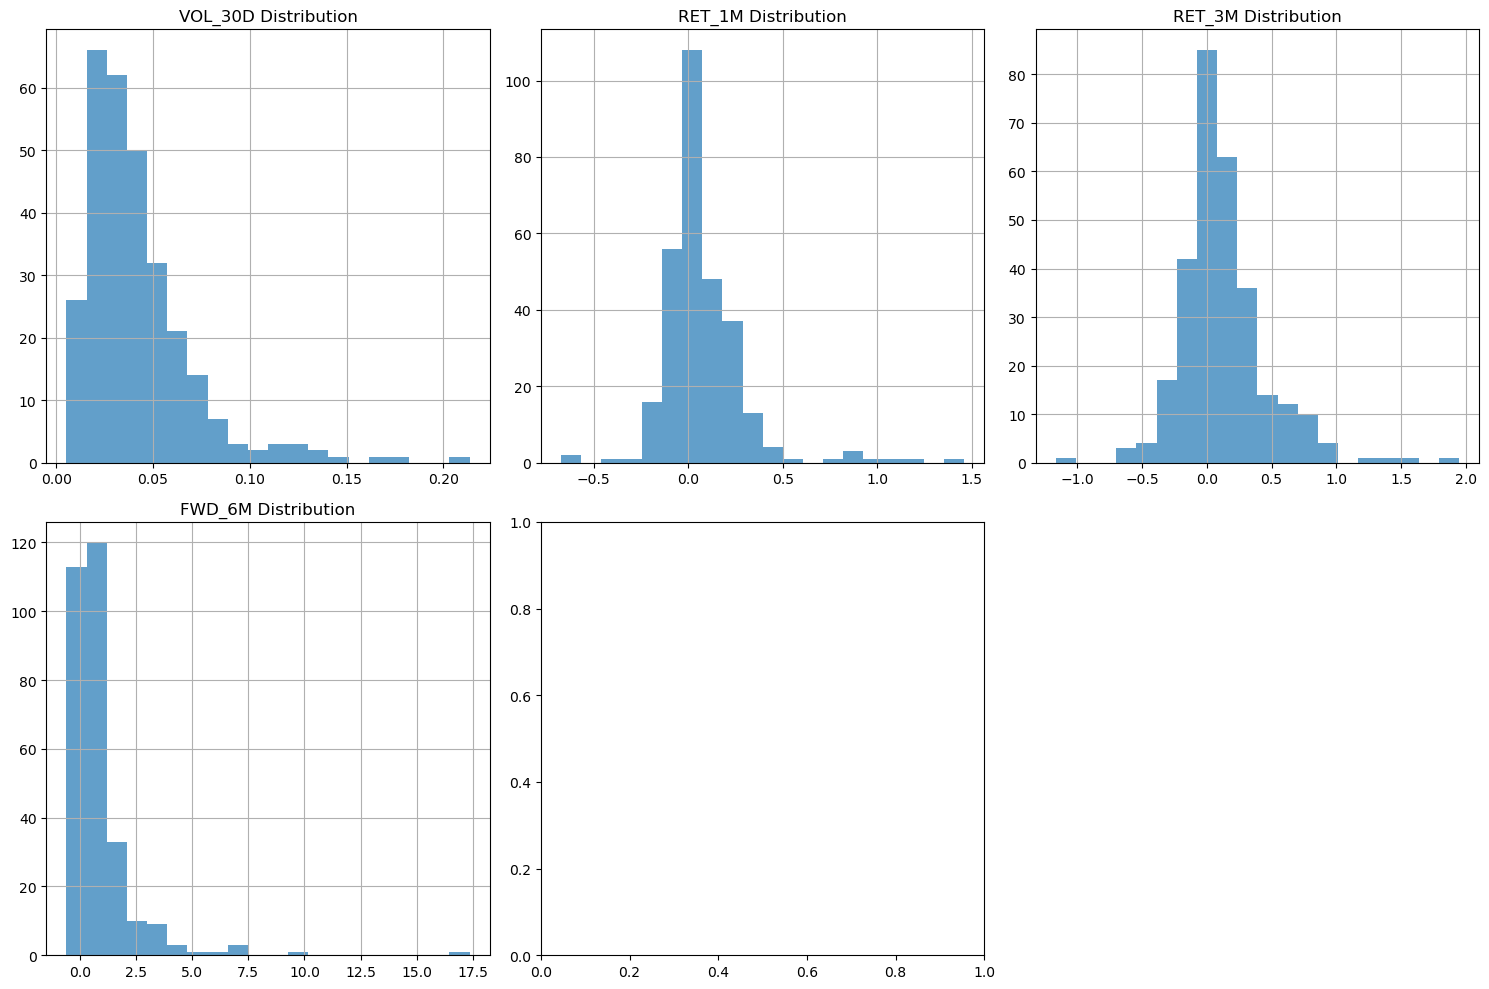


--- Step 5: Fetching Clinical Trials ---
Fetching trial data (this may take time)...

Completed. Final dataset saved: 295 companies.
phase_1          778
phase_2         1917
phase_3         1177
phase_4          151
total_trials    5196
dtype: int64


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import time
import json
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap

# ==========================================
# 1. SETUP & TICKER MAPPING
# ==========================================
print("--- Step 1: Loading Tickers & Metadata ---")

# Load ETF Holdings (Assumes files exist in directory)
ibb = pd.read_csv('data/IBB_holdings.csv', skiprows=9)
ibb = ibb[ibb['Asset Class'] == 'Equity'][['Ticker', 'Name']].dropna()

xbi = pd.read_csv('data/holdings-daily-us-en-xbi.csv', skiprows=4)
xbi = xbi[['Ticker', 'Name']].dropna()

# Combine and Clean
etf_data = pd.concat([ibb, xbi], ignore_index=True)
etf_data['Ticker'] = etf_data['Ticker'].str.strip()
etf_data['Name'] = etf_data['Name'].str.strip()
etf_data = etf_data[etf_data['Ticker'].apply(lambda t: bool(re.match(r'^[A-Z]{1,5}$', str(t))))]

# Define Original 48 Mapping
original_48_mapping = {
    "VRTX": "Vertex Pharmaceuticals Incorporated", "AMGN": "Amgen", "GILD": "Gilead Sciences",
    "REGN": "Regeneron Pharmaceuticals", "ALNY": "Alnylam Pharmaceuticals", "IQV": "IQVIA Inc.",
    "BIIB": "Biogen", "ILMN": "ILLUMINA, INC.", "INCY": "Incyte Corporation",
    "BMRN": "BioMarin Pharmaceutical", "EXEL": "Exelixis", "MRNA": "Moderna Therapeutics, Inc.",
    "ACAD": "ACADIA Pharmaceuticals Inc.", "SRPT": "Sarepta Therapeutics", "JAZZ": "Jazz Pharmaceuticals",
    "DXCM": "DexCom, Inc.", "IDXX": "IDEXX Laboratories, Inc.", "ISRG": "Intuitive Surgical",
    "TECH": "Bio-Techne Corporation", "EW": "Edwards Lifesciences", "MEDP": "Medpace, Inc.",
    "NTRA": "Natera, Inc.", "PEN": "Penumbra Inc.", "PODD": "Insulet Corporation",
    "TMDX": "TransMedics", "VTRS": "Viatris Inc.", "WST": "West Pharmaceutical Services, Inc.",
    "ZBH": "Zimmer Biomet", "ABT": "Abbott Medical Devices", "ABBV": "AbbVie",
    "BMY": "Bristol-Myers Squibb", "PFE": "Pfizer", "MRK": "Merck Sharp & Dohme LLC",
    "JNJ": "Johnson & Johnson Pharmaceutical Research & Development, L.L.C.", "LLY": "Eli Lilly and Company",
    "NVO": "Novo Nordisk A/S", "AZN": "AstraZeneca", "TAK": "Takeda",
    "TEVA": "Teva Branded Pharmaceutical Products R&D, Inc.", "BNTX": "BioNTech SE",
    "AXSM": "Axsome Therapeutics, Inc.", "NBIX": "Neurocrine Biosciences", "IONS": "Ionis Pharmaceuticals, Inc.",
    "GMAB": "Genmab", "UTHR": "United Therapeutics", "WAT": "Waters Corporation",
    "MTD": "Mettler-Toledo International Inc.", "RMD": "ResMed"
}

# Final Mapping
TICKER_TO_SPONSOR = dict(zip(etf_data['Ticker'], etf_data['Name']))
TICKER_TO_SPONSOR.update(original_48_mapping)
expanded_tickers = sorted(list(TICKER_TO_SPONSOR.keys()))

# ==========================================
# 2. DATA DOWNLOAD
# ==========================================
print(f"\n--- Step 2: Downloading Data for {len(expanded_tickers)} Tickers ---")

def download_valid_stocks(tickers):
    valid_data = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start="2023-01-01", end="2025-12-30", auto_adjust=True)
            if len(hist) > 30:
                valid_data[ticker] = hist
        except:
            pass
        time.sleep(0.2)
    return valid_data

valid_stocks = download_valid_stocks(expanded_tickers)

if valid_stocks:
    combined = pd.concat(valid_stocks, axis=1, keys=valid_stocks.keys())
    combined.to_csv('data/ibb_valid_stocks_expanded.csv') # Checkpoint
    
    valid_tickers = list(valid_stocks.keys())
    pd.DataFrame({'ticker': valid_tickers}).to_csv('data/ibb_valid_ticker_expanded.csv', index=False)
    print("Download complete. Data saved.")
else:
    raise ValueError("No valid stocks downloaded.")

# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================
print("\n--- Step 3: Generating Features ---")

# Process Prices (In-memory derived from 'combined' to avoid reloading)
# Note: combined columns are MultiIndex (Ticker, Price Type)
prices = combined.xs('Close', level=1, axis=1, drop_level=True)
prices.index = pd.to_datetime(prices.index, utc=True).tz_localize(None).normalize()

# Ensure numeric and clean
prices_numeric = prices.apply(pd.to_numeric, errors='coerce')
prices_numeric = prices_numeric.dropna(axis=1, how='all')

# 3a. IBB Benchmark Check - FIX APPLIED HERE
ibb_df = yf.download("IBB", start=prices.index.min(), end=prices.index.max(), progress=False)

# Handle yfinance MultiIndex return (force to single Series)
if isinstance(ibb_df.columns, pd.MultiIndex):
    try:
        ibb_data = ibb_df.xs('Close', level=0, axis=1).iloc[:, 0] # Grab first column if multiple
    except:
        ibb_data = ibb_df['Close'] # Fallback
else:
    ibb_data = ibb_df['Close']

ibb_data.index = pd.to_datetime(ibb_data.index, utc=True).tz_localize(None).normalize()

fwd_6m_ibb = ibb_data.shift(-126) / ibb_data - 1.0
fwd_6m_stocks_check = prices_numeric.shift(-126) / prices_numeric - 1.0
valid_stock_returns = fwd_6m_stocks_check.dropna()
valid_ibb_returns = fwd_6m_ibb.dropna()
common_dates = valid_stock_returns.index.intersection(valid_ibb_returns.index)

if len(common_dates) > 0:
    ref_date_check = common_dates[-1]
    # FIX: Use .iloc[0] if it's a Series, or simple extraction
    val = fwd_6m_ibb.loc[ref_date_check]
    if isinstance(val, (pd.Series, pd.DataFrame, np.ndarray)):
         ibb_hurdle = float(val.iloc[0]) if hasattr(val, 'iloc') else float(val.item())
    else:
         ibb_hurdle = float(val)
            
    print(f"Latest Valid Ref Date: {ref_date_check.date()} | IBB Hurdle: {ibb_hurdle:.4f}")
else:
    print("Warning: No overlapping dates for IBB hurdle check.")

# 3b. Feature Calculation
returns = prices_numeric.pct_change()
vol_30d = returns.rolling(window=30).std()
ret_1m = returns.rolling(window=21).sum()
ret_3m = returns.rolling(window=63).sum()
fwd_6m = prices_numeric.shift(-126) / prices_numeric - 1.0

# Robust Reference Date logic
not_na_counts = fwd_6m.notna().sum(axis=1)
valid_dates = not_na_counts[not_na_counts > (len(prices_numeric.columns) * 0.1)].index
if len(valid_dates) == 0:
    valid_dates = fwd_6m.index[fwd_6m.notna().any(axis=1)]
ref_date = valid_dates[-1]

features = []
for ticker in prices_numeric.columns:
    if pd.notna(fwd_6m.loc[ref_date, ticker]):
        features.append({
            "ticker": ticker,
            "vol_30d": vol_30d.loc[ref_date, ticker],
            "ret_1m": ret_1m.loc[ref_date, ticker],
            "ret_3m": ret_3m.loc[ref_date, ticker],
            "fwd_6m": fwd_6m.loc[ref_date, ticker]
        })

df_features = pd.DataFrame(features).set_index("ticker")
df_features = df_features.dropna()

# Labeling
threshold = 0.362518
df_features["label"] = (df_features["fwd_6m"] > threshold).astype(int)
df_features.to_csv("data/stock_expanded_features.csv")
print(f"Features saved for {len(df_features)} tickers.")

# ==========================================
# 4. EDA & PERFORMANCE ANALYSIS
# ==========================================
print("\n--- Step 4: EDA & Visualizations ---")

# Use df_features as 'df' for EDA
df = df_features.copy()

# Basic Stats
print("\nLabel distribution:\n", df['label'].value_counts(normalize=True).round(3))
corr = df[['vol_30d', 'ret_1m', 'ret_3m', 'fwd_6m', 'label']].corr()
print("\nCorrelations with Label:\n", corr['label'].sort_values(ascending=False).round(3))

# Plot 1: Distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
cols = ['vol_30d', 'ret_1m', 'ret_3m', 'fwd_6m']
for i, feat in enumerate(cols):
    ax = axes[i//3, i%3]
    df[feat].hist(bins=20, alpha=0.7, ax=ax)
    ax.set_title(f'{feat.upper()} Distribution')
axes[1,2].remove()
plt.tight_layout()
plt.show()

# ==========================================
# 5. CLINICAL TRIALS INTEGRATION
# ==========================================
print("\n--- Step 5: Fetching Clinical Trials ---")

def fetch_trials_direct(sponsor_name):
    url = "https://clinicaltrials.gov/api/v2/studies"
    trials = {'phase_1': 0, 'phase_2': 0, 'phase_3': 0, 'phase_4': 0, 'active_trials': 0, 'total_trials': 0}
    next_page_token = None
    try:
        while True:
            params = {
                'query.spons': f'"{sponsor_name}"',
                'pageSize': 1000,
                'filter.overallStatus': 'RECRUITING,ACTIVE_NOT_RECRUITING'
            }
            if next_page_token:
                params['pageToken'] = next_page_token
            
            response = requests.get(url, params=params, timeout=15)
            if response.status_code != 200: break
                
            data = response.json()
            for study in data.get('studies', []):
                design = study.get('protocolSection', {}).get('designModule', {})
                phase_str = "".join(design.get('phases', [])).lower()
                
                if 'phase3' in phase_str: trials['phase_3'] += 1
                elif 'phase2' in phase_str: trials['phase_2'] += 1
                elif 'phase1' in phase_str: trials['phase_1'] += 1
                elif 'phase4' in phase_str: trials['phase_4'] += 1
                trials['total_trials'] += 1
            
            next_page_token = data.get('nextPageToken')
            if not next_page_token: break
                
        trials['active_trials'] = trials['total_trials']
        return trials
    except Exception as e:
        print(f"Error fetching {sponsor_name}: {e}")
        return trials

# Use in-memory list and df from previous steps
tickers = df_features.index.tolist()
trial_features = {}

print("Fetching trial data (this may take time)...")
for ticker in tickers: 
    if ticker in TICKER_TO_SPONSOR:
        sponsor = TICKER_TO_SPONSOR[ticker]
        # print(f"Fetching {ticker}: {sponsor}") # Uncomment for verbose output
        trial_features[ticker] = fetch_trials_direct(sponsor)
        time.sleep(0.5)
    else:
        trial_features[ticker] = {'phase_1': 0, 'phase_2': 0, 'phase_3': 0, 'phase_4': 0, 'active_trials': 0, 'total_trials': 0}

# Merge and Save Final
df_trials = pd.DataFrame(trial_features).T
df_combined = df_features.join(df_trials, how='left').fillna(0)

# Derived Metrics
df_combined['pipeline_density'] = df_combined['phase_3'] / (df_combined['total_trials'] + 1)
df_combined['late_stage_ratio'] = (df_combined['phase_3'] + df_combined['phase_4']) / (df_combined['total_trials'] + 1)
df_combined['risk_score'] = df_combined['phase_1'] / (df_combined['phase_3'] + df_combined['phase_4'] + 1)

df_combined.to_csv("data/gnn_features_expanded_final.csv")
print(f"\nCompleted. Final dataset saved: {len(df_combined)} companies.")
print(df_combined[['phase_1','phase_2','phase_3','phase_4','total_trials']].sum().round(0))

* From the EDA plots we can identify that *most biotech stocks have low to medium volatility and returns* of the same nature, with **some stocks showing extreme price swings atypical of financial markets**, but expected in biotech markets due to sudden announcements pertaining to clincal trials and research advancements along with regulatory changes.

* This *justifies using multimodal approach for classifying the stocks into regimes of BUY, HOLD and SELL* with representation learning as the core model, as **using historical financial data as the only source would be a disadvantage** in this specific market ie: biotech and pharmaceuticals.

# Filtering of ticker universe for quality control and computational robustness.

  * The tickers are reduced in number from 300 to 50 ie: from the entire holding of IBB-ETF to a manually curated 50 that includes a fair and balanced representation across market cap. 
  * The same tickers are used as reference for stock data pulling through yfinance API, care is taken here to adhere to a three year timeline spanning from 2020 to 2023 as the dowsntream clinical data we use using the [clinicaltrials.gov](https://clinicaltrials.gov/data-api/about-api/csv-download) API has its latest data on January-2023. The logic behind this choice is we need our market data to align with the clinincal data temporally as our hypothesis assumes close relation to each other and it makes sense intuitively.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

tickers = [
    'LLY', 'JNJ', 'ABBV', 'AZN', 'MRK', 'NVO', 'ABT', 'ISRG', 'AMGN', 'GILD', 
    'PFE', 'VRTX', 'BMY', 'REGN', 'IDXX', 'ALNY', 'ARGX', 'TAK', 'EW', 'IQV', 
    'INSM', 'TEVA', 'RMD', 'ONC', 'NTRA', 'MTD', 'DXCM', 'BIIB', 'BNTX', 'WAT', 
    'UTHR', 'ILMN', 'PODD', 'WST', 'GMAB', 'INCY', 'EXAS', 'ZBH', 'MEDP', 'RVMD', 
    'ROIV', 'BBIO', 'VTRS', 'NBIX', 'MDGL', 'SMMT', 'IONS', 'ASND', 'PEN', 'MRNA'
]

start_date = "2020-02-01"
end_date = "2023-02-01"

data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
data.head()

[*********************100%***********************]  50 of 50 completed


Ticker             IQV                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2020-02-03  156.600006  157.220001  154.940002  155.250000  1786100   
2020-02-04  157.119995  157.589996  155.619995  157.039993  3384300   
2020-02-05  159.059998  161.550003  158.380005  159.759995  1373300   
2020-02-06  160.639999  161.250000  159.789993  160.529999   976600   
2020-02-07  160.309998  160.610001  156.979996  157.000000  1193000   

Ticker           INSM                                            ...  \
Price            Open       High        Low      Close   Volume  ...   
Date                                                             ...   
2020-02-03  30.090000  30.440001  27.020000  28.879999  9876600  ...   
2020-02-04  29.590000  33.630001  28.889999  33.040001  3853300  ...   
2020-02-05  33.290001  34.029999  32.330002  33.980000  2647700  ...   
2020-02-06  34.029999  34.939999  33.200001  33.250000  1369200  ...   
2020-02-07  33.090000  33.480000  32.410000  32.919998  1350300  ...   

Ticker             EW                                                  PFE  \
Price            Open       High        Low      Close   Volume       Open   
Date                                                                         
2020-02-03  73.166664  74.760002  73.000000  73.306664  6823500  27.028792   
2020-02-04  74.463333  76.120003  74.286667  75.449997  4120800  27.476145   
2020-02-05  75.769997  77.143333  75.769997  77.043335  5157600  27.310199   
2020-02-06  77.613335  78.893333  76.826668  78.879997  4488600  27.735898   
2020-02-07  78.550003  78.620003  76.976669  77.470001  3289200  27.678182   

Ticker                                                 
Price            High        Low      Close    Volume  
Date                                                   
2020-02-03  27.447284  26.913344  27.064867  20875735  
2020-02-04  27.591590  27.151453  27.194746  31150865  
2020-02-05  27.829707  27.288554  27.541090  29443490  
2020-02-06  27.779191  27.440067  27.606020  21047748  
2020-02-07  27.707042  27.367920  27.454506  21903596  

[5 rows x 250 columns]

Converting into longform for LSTM processing

In [2]:
all_data = []
for ticker in tickers:
    if ticker in data:
        t_data = data[ticker].copy()
        t_data['ticker'] = ticker
        all_data.append(t_data)

stock_df = pd.concat(all_data).reset_index()

stock_df.to_csv("data/stock_csv.csv", index=False)
print("Data saved to CSV file in directory")

Data saved to CSV file in directory


# Preprocessing and loading the data for training.

In [3]:
stock_df = pd.read_csv("data/stock_csv.csv", parse_dates=['Date'], dayfirst=False)
clinical_df = pd.read_csv("data/clinical_csv.csv")
clinical_df = clinical_df.drop(columns=('Unnamed: 0'))
stock_ticker = sorted(set(stock_df['ticker'].unique()))
clinical_df = clinical_df.dropna()
clinical_ticker = sorted(set(clinical_df['ticker'].unique()))
common_ticker = set(stock_ticker) & set(clinical_ticker)
clinical_df = clinical_df.set_index('ticker').loc[list(common_ticker)]
clinical_df = clinical_df.reindex(stock_df['ticker'].unique())

**EDA for sanity check.**

* The dataset is checked for duplicate ticker entries and index-wise match in both modalities of data for concurrency downstream. -> Successful data alignment with no duplications.
* Individual tickers are spot checked for summarising and ditribution analysis. -> Substantial heterogenerity across universe seen in clinical aspects typical of biotech market with varying pipeline density and concentration. Stock features appear continouse and liquid with varying volatility.
* Coverage is checked for analysing wether sufficient data is available for selected tickers. -> Majority of tickers have complete data spanning  755 days (3 years) indicating good data population
* Volume distribution is heavily right skewed by highly liquid large cap stocks for which we apply log1p(x) normalisation to take care of statistical robustness while handling zero/near zero values.
* We also calculate volatilty per ticker using standard deviation of daily close values via simple return method. 
* Correlation and count check between features are also done to remove collinear features thus reducing computational redundancy in LSTM and PCA layers while also noting that many tickers have sparse clinical trial data. Which is why we are using clinical trial data as complementary information in our pipeline in the later machine learning stages rather than the stock data series utilising LSTM in the earlier phase.

PODD
phase_1          0.000000
phase_2          0.693147
phase_3          0.000000
phase_4          0.000000
active_trials    1.098612
Name: PODD, dtype: float64
            Date        Open        High         Low       Close    Volume  \
24160 2020-02-03  195.250000  196.889999  194.270004  194.839996  442800.0   
24161 2020-02-04  197.860001  200.460007  196.570007  197.720001  462800.0   
24162 2020-02-05  198.940002  199.970001  193.960007  194.300003  403200.0   
24163 2020-02-06  194.830002  202.399994  194.460007  198.410004  410900.0   
24164 2020-02-07  198.240005  202.369995  197.000000  200.029999  400100.0   

      ticker  
24160   PODD  
24161   PODD  
24162   PODD  
24163   PODD  
24164   PODD  
----------------------------------------
TEVA
phase_1          0.0
phase_2          0.0
phase_3          0.0
phase_4          0.0
active_trials    0.0
Name: TEVA, dtype: float64
            Date   Open   High    Low  Close      Volume ticker
15855 2020-02-03  10.57  11.19  10.49

/tmp/ipykernel_9730/2532488278.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vol_df = stock_df.groupby('ticker').apply(compute_volatility)


,phase_1,phase_2,phase_3,phase_4,active_trials,total_trials,late_stage_ratio,pipeline_density
phase_1,1.000000,0.961415,0.906100,0.749292,0.891375,0.891375,0.810185,0.548687
phase_2,0.961415,1.000000,0.925338,0.747513,0.903419,0.903419,0.833713,0.586721
phase_3,0.906100,0.925338,1.000000,0.782758,0.875736,0.875736,0.946912,0.496446
phase_4,0.749292,0.747513,0.782758,1.000000,0.717803,0.717803,0.722487,0.289461
active_trials,0.891375,0.903419,0.875736,0.717803,1.000000,1.000000,0.830029,0.757774
total_trials,0.891375,0.903419,0.875736,0.717803,1.000000,1.000000,0.830029,0.757774
late_stage_ratio,0.810185,0.833713,0.946912,0.722487,0.830029,0.830029,1.000000,0.552246
pipeline_density,0.548687,0.586721,0.496446,0.289461,0.757774,0.757774,0.552246,1.000000


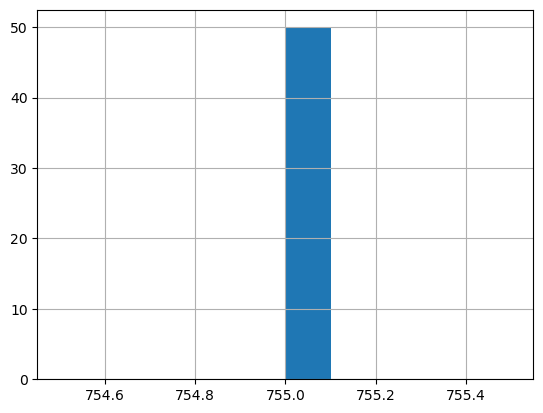

In [4]:
# 1. No duplicates in clinical index
assert clinical_df.index.is_unique

# 2. Same tickers in both
assert set(clinical_df.index) == set(stock_df['ticker'].unique())

# 3. Spot-check a few tickers
for t in list(common_ticker)[:5]:
    print(t)
    print(clinical_df.loc[t].head())
    print(stock_df[stock_df['ticker'] == t].head())
    print("-"*40)

coverage = (
    stock_df.groupby('ticker')['Date']
    .agg(['min', 'max', 'count'])
    .rename(columns={'count':'num_days'})
)

coverage['years'] = (coverage['max'] - coverage['min']).dt.days / 365
coverage.describe()


coverage['num_days'].hist(bins=10)
stock_df[['Close', 'Volume']].describe()


stock_df['log_volume'] = np.log1p(stock_df['Volume'])
stock_df['log_volume'].describe()
stock_df['log_volume'] = np.log1p(stock_df['Volume'])
stock_df['log_volume'].describe()
stock_df['Volume'] = stock_df['log_volume']
stock_df = stock_df.drop(columns=('log_volume'))
def compute_volatility(df):
    prices = df['Close'].values
    returns = np.diff(prices) / prices[:-1]
    return np.nanstd(returns)

vol_df = stock_df.groupby('ticker').apply(compute_volatility)
vol_df.describe()
clinical_df.describe()

count_cols = [
    'phase_1', 'phase_2', 'phase_3', 'phase_4',
    'total_trials', 'active_trials'
]

(clinical_df[count_cols] == 0).mean()

clinical_df.corr()



# Time series tensor construction and normalisation post mask creation.

* The processed stock feature historical data is transformed into tensor format to be processed by our LSTM with the resulting tensor having (N,T,F) dimensions {N: No. of Stocks, T: Timestep, F: Stock Features}, this is passed as 'price_array'. 
* Another array 'mask_array' is passed that contains a boolean mask of shape (N, T) to indicate which timestamps to consider as valid observations in features per ticker at respective timestamp. This is done to ensure only real data is passed onto the model for training rather than crude imputing of values to achieve the objective but destabilising the dataset with zeros or other substitute values such as median that deter the learning capability of the model.  

In [5]:
feature_list = stock_df.columns.tolist()
feature_list = feature_list[1:-1]
feature_list

['Open', 'High', 'Low', 'Close', 'Volume']

In [6]:
tickers = stock_df['ticker'].unique()
print(tickers)
tickers = stock_df['ticker'].unique()
print(tickers)
N = len(tickers)
print(N)
F = len(feature_list)
print(F)
T = len(set(stock_df['Date'].unique()))
print(T)

price_ref_col = 'Close'   # or 'Adj Close' if you have it
dates = sorted(stock_df['Date'].unique())
date_to_idx = {d: i for i, d in enumerate(dates)}

T = len(dates)
N = len(tickers)
F = len(feature_list)

price_array = np.zeros((N, T, F), dtype=np.float32)
mask_array  = np.zeros((N, T), dtype=bool)

for i, ticker in enumerate(tickers):
    df_t = stock_df[stock_df['ticker'] == ticker]

    for _, row in df_t.iterrows():
        t_idx = date_to_idx[row['Date']]

        # Fill features
        price_array[i, t_idx, :] = row[feature_list].values

        # Mask is TRUE only if price is valid
        if not np.isnan(row[price_ref_col]):
            mask_array[i, t_idx] = True

mask_array.sum(axis=1)

print("Sequence building complete.")
print("Price Array Shape:", price_array.shape)
print("Mask Array Shape:", mask_array.shape)
        
import numpy as np

lengths = mask_array.sum(axis=1)

print("Min real days:", lengths.min())
print("Max real days:", lengths.max())
print("Mean real days:", lengths.mean())


['LLY' 'JNJ' 'ABBV' 'AZN' 'MRK' 'NVO' 'ABT' 'ISRG' 'AMGN' 'GILD' 'PFE'
 'VRTX' 'BMY' 'REGN' 'IDXX' 'ALNY' 'ARGX' 'TAK' 'EW' 'IQV' 'INSM' 'TEVA'
 'RMD' 'ONC' 'NTRA' 'MTD' 'DXCM' 'BIIB' 'BNTX' 'WAT' 'UTHR' 'ILMN' 'PODD'
 'WST' 'GMAB' 'INCY' 'EXAS' 'ZBH' 'MEDP' 'RVMD' 'ROIV' 'BBIO' 'VTRS'
 'NBIX' 'MDGL' 'SMMT' 'IONS' 'ASND' 'PEN' 'MRNA']
['LLY' 'JNJ' 'ABBV' 'AZN' 'MRK' 'NVO' 'ABT' 'ISRG' 'AMGN' 'GILD' 'PFE'
 'VRTX' 'BMY' 'REGN' 'IDXX' 'ALNY' 'ARGX' 'TAK' 'EW' 'IQV' 'INSM' 'TEVA'
 'RMD' 'ONC' 'NTRA' 'MTD' 'DXCM' 'BIIB' 'BNTX' 'WAT' 'UTHR' 'ILMN' 'PODD'
 'WST' 'GMAB' 'INCY' 'EXAS' 'ZBH' 'MEDP' 'RVMD' 'ROIV' 'BBIO' 'VTRS'
 'NBIX' 'MDGL' 'SMMT' 'IONS' 'ASND' 'PEN' 'MRNA']
50
5
755
Sequence building complete.
Price Array Shape: (50, 755, 5)
Mask Array Shape: (50, 755)
Min real days: 540
Max real days: 755
Mean real days: 750.54


* Mask Aware Z-Score normalisation of per stock features is carried out with safeguards for handling NaNs and near zero-variance features (by replacing mean and standard deviation values of features that return NaN with the 0 and 1 values)
* Missing values are set to zero after normalization to maintain numerical stability if any.

In [7]:
price_array_z = np.zeros_like(price_array, dtype=np.float32)
eps = 1e-8

for i in range(N):
    obs = mask_array[i]

    if obs.sum() == 0:
        continue

    observed = price_array[i, obs, :]  # (L, F)

    # Handle NaNs inside observed data ---
    # Compute mean/std ignoring NaNs
    mean = np.nanmean(observed, axis=0)
    std  = np.nanstd(observed, axis=0)

    # Guards
    mean = np.nan_to_num(mean, nan=0.0)
    std  = np.nan_to_num(std, nan=1.0)
    std  = np.where(std < eps, 1.0, std)

    # Normalize
    price_array_z[i] = (price_array[i] - mean) / std

    # set NaNs back to zero after normalization
    price_array_z[i] = np.nan_to_num(price_array_z[i], nan=0.0)


# LSTM layer construction and training.

* The model is an LSTM based encoder-decoder architecture meant to learn the representation of each stock over the entire time stamp using the stock features acting as a summariser by projecting the 5 features across 750 days into 32 dimensional latent space that holds the key information on the market behaviour of the stock.
* We use the torch module to create model class that details the architecture that has 5 input features, 32 hidden dimensions for both the encoder and decoder that returns the encoded and decoded values per iteration for loss calculation.
* The loss calculation is performed using MSE (Mean Squared Error) function manually implemented that is mask aware. It essentially calculates the squared sum of difference between reconstructed tensor and original tensor representation of feature multiplied by mask value and the whole divided by the value of sum of all the True boolean values of the mask array for that stock.

In [8]:
import torch
import torch.nn as nn

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        # Encoder compresses features, not time
        self.encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True
        )

        # Decoder reconstructs features per timestep
        self.decoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True
        )

        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        """
        x: (batch, T, F)
        """
        encoded_seq, _ = self.encoder(x)      # (batch, T, hidden_dim)
        decoded_seq, _ = self.decoder(encoded_seq)
        recon = self.output_layer(decoded_seq)
        return recon, encoded_seq

input_dim  = price_array_z.shape[2]  # F = 5
hidden_dim = 32
num_layers = 2

def masked_mse_loss(recon, target, mask, eps=1e-8):
    """
    recon:  (batch, T, F)
    target: (batch, T, F)
    mask:   (batch, T)
    """
    mask = mask.unsqueeze(-1).float()  # (batch, T, 1)

    diff = (recon - target) ** 2
    diff = diff * mask

    denom = mask.sum()

    
    return diff.sum() / (denom + eps)




* A class is created for loading the numpy array data to be fed into the model properly that has functions that determine when an epoch is completed and within each epoch to obtain the feature values and corresponding mask values for feeding to LSTM.
* 8 stocks are parallely processed together by the batch size parameter and the batches are shuffled for better generalisation.

In [9]:
from torch.utils.data import Dataset, DataLoader
class PriceDataset(Dataset):
    def __init__(self, price_array, mask_array):
        self.x = torch.tensor(price_array, dtype=torch.float32)
        self.mask = torch.tensor(mask_array, dtype=torch.bool)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.mask[idx]

dataset = PriceDataset(price_array_z, mask_array)

dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True
)


* The training of the model is carried out here using adam optimiser, learning rate of 0.001 and 100 epochs with proper loss logging for on training evaluation. These hyperparameters were manually chosen over several training runs, due to increased performance indications while model evaluation specifically with 32 hidden dimensions.
* Fail safes are implemented to detect NaN values in loss and reconstructions for early stoppage.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMAutoencoder(
    input_dim=input_dim,
    hidden_dim=hidden_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 101

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    batches = 0

    for x, mask in dataloader:
        x = x.to(device)
        mask = mask.to(device)

        recon, z = model(x)

        if torch.isnan(recon).any():
            raise RuntimeError("NaNs in recon output")

        loss = masked_mse_loss(recon, x, mask)

        if torch.isnan(loss):
            raise RuntimeError("NaN loss detected")

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batches += 1

    epoch_loss /= max(batches, 1)

    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Reconstruction Loss: {epoch_loss:.6f}")


Epoch 2/101 | Reconstruction Loss: 4.989841
Epoch 4/101 | Reconstruction Loss: 4.345571
Epoch 6/101 | Reconstruction Loss: 3.157060
Epoch 8/101 | Reconstruction Loss: 2.840261
Epoch 10/101 | Reconstruction Loss: 3.526594
Epoch 12/101 | Reconstruction Loss: 3.065303
Epoch 14/101 | Reconstruction Loss: 2.822027
Epoch 16/101 | Reconstruction Loss: 3.139939
Epoch 18/101 | Reconstruction Loss: 3.230550
Epoch 20/101 | Reconstruction Loss: 2.660751
Epoch 22/101 | Reconstruction Loss: 2.850918
Epoch 24/101 | Reconstruction Loss: 3.155355
Epoch 26/101 | Reconstruction Loss: 3.148162
Epoch 28/101 | Reconstruction Loss: 2.926339
Epoch 30/101 | Reconstruction Loss: 2.671680
Epoch 32/101 | Reconstruction Loss: 2.707207
Epoch 34/101 | Reconstruction Loss: 2.383467
Epoch 36/101 | Reconstruction Loss: 1.847302
Epoch 38/101 | Reconstruction Loss: 2.109221
Epoch 40/101 | Reconstruction Loss: 2.184329
Epoch 42/101 | Reconstruction Loss: 2.159392
Epoch 44/101 | Reconstruction Loss: 2.229161
Epoch 46/101 |

* The model is evaluated with no gradient calculation and single ticker forward pass.
* The original values are plotted with blue line and orange line shows reconstructed values and the plot indicates capturing of the overall trend of the ticker throughout positive mask values rather than perfectly learn every datapoint, which aligns with out desired goal with this model. ie: To summarise the market behaviour of the stock over a period of time.

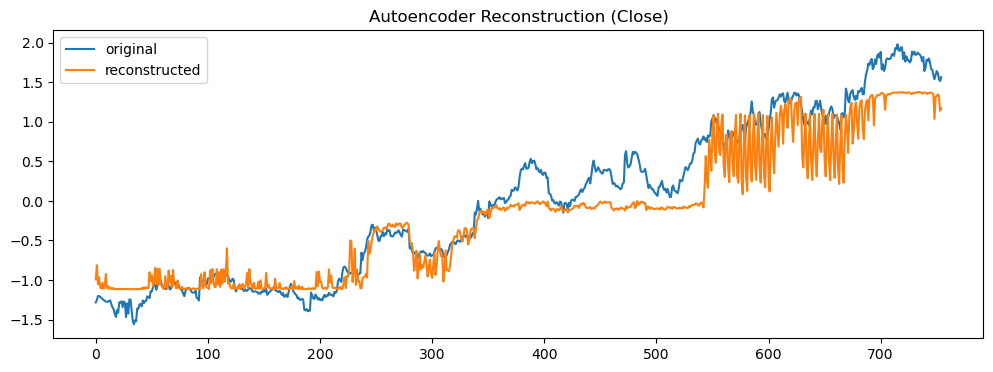

In [11]:
model.eval()

with torch.no_grad():
    x = torch.tensor(price_array_z[0:1], dtype=torch.float32).to(device)
    mask = mask_array[0]

    recon, z = model(x)
    recon = recon.cpu().numpy()[0]

import matplotlib.pyplot as plt

f = feature_list.index('Close')
t = np.where(mask)[0]

plt.figure(figsize=(12,4))
plt.plot(t, price_array_z[0, t, f], label='original')
plt.plot(t, recon[t, f], label='reconstructed')
plt.legend()
plt.title("Autoencoder Reconstruction (Close)")
plt.show()


* Feature extraction is carried out here with the final matrix having all the tickers as rows and each stock's entire market behavious throughout the timespan represented as 32 features (N, 32). 
* This is done by forward passing through the model once for all ticker and multiplying the the 32 dimension vector for each ticker per timestamp with corresponding boolean value and then adding all these timestamp values after which it is divided by the sum of boolean values across all timestamps. This is called masked global average pooling.
* Then these values are stacked together vertically to get the final matrix.

In [12]:
model.eval()

embeddings = []

with torch.no_grad():
    for x, mask in dataloader:
        x = x.to(device)
        mask = mask.to(device)

        _, encoded_seq = model(x)   # (batch, T, hidden_dim)

        mask_f = mask.unsqueeze(-1).float()
        emb = (encoded_seq * mask_f).sum(dim=1) / mask_f.sum(dim=1)

        embeddings.append(emb.cpu().numpy())
        

embeddings = np.vstack(embeddings)  # (N, hidden_dim)


* PCA is used to collapse the model values to 2 principal components and the results show clear seperation between stocks that are different in market activity and historical behaviour.
* Tickers like MRNA (Moderna) and NBIX (Neurocrine) along with several others such as REGN (Regeneron) and ALNY (Alnylam) showing similar behaviour
* Outliers such as IDXX and PEN show great market difference from the above mentioned central cluster along with TAK and RMD albiet in an opposite manner. 

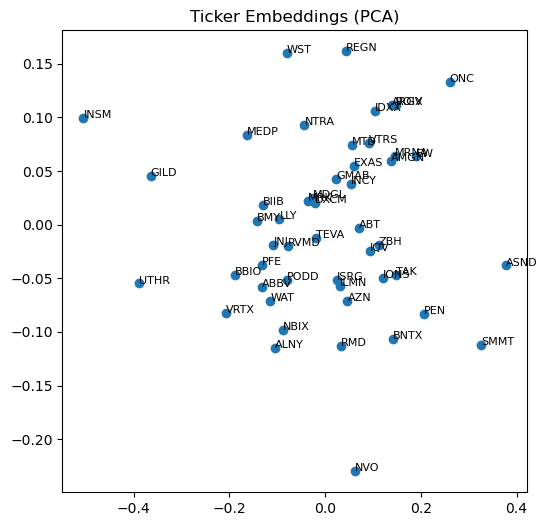

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(6,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1])
for i, t in enumerate(tickers):
    plt.text(emb_2d[i,0], emb_2d[i,1], t, fontsize=8)
plt.title("Ticker Embeddings (PCA)")
plt.show()



# Feature fusion and PCA based regime classification.

* We combine the 32 features per ticker representation created by LSTM using stock features that encode the summary of market performance with the clinical features we derived per ticker to be processed by PCA.
* The clinical features are globally scaled by standard scaler already before the csv is loaded and the total and active trial features are dropped due to high correlation.
* The PC1 shows most variance with a clear linear seperation of tickers when the features are combined. 
* Regime classification is carried out using PC1 scores of tickers after Z-score normalisation and ranking.
* A score of above 0.7 classifies as BUY, and a score of less than 0.3 as SELL, with anything in between as HOLD.

In [14]:
print(embeddings.shape)
clin_features_scaled = pd.read_csv("data/clinical_mlp.csv")
clin_features_scaled = clin_features_scaled.drop(columns=('Unnamed: 0'))
print(clin_features_scaled.shape)

(50, 32)
(50, 6)


In [15]:
X_fused = np.concatenate(
    [embeddings, clin_features_scaled],
    axis=1
)
X_fused.shape 


(50, 38)

In [16]:
print(
    embeddings.std(),
    clin_features_scaled.std()
)


0.18576875 phase_1         0.092836
phase_2         0.202340
phase_3         0.210357
phase_4         0.028594
late_ratio      0.223682
active_ratio    0.443087
dtype: float64


In [17]:
# Requirements
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
import scipy.stats as stats

# X_fused: (N, D) numpy array (embeddings concatenated with clinical_scaled)
# tickers: list of tickers order

# 1) Fit PCA(1)
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_fused)  # shape (N,)

pc1 = pcs[:, 0]
pc2 = pcs[:, 1]

# 2) Standardize scores for interpretability (mean=0, std=1)
scores = (pc1 - pc1.mean()) / (pc1.std(ddof=0) + 1e-8)

# 3) Percentiles and regimes
percentiles = stats.rankdata(scores) / len(scores)
regimes = np.where(percentiles >= 0.7, "BUY",
          np.where(percentiles <= 0.3, "SELL", "HOLD"))




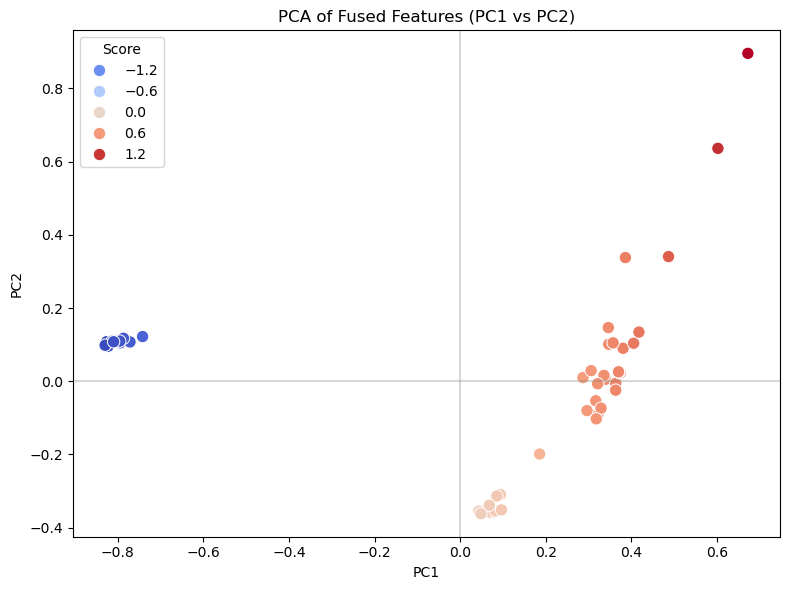

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

viz_df = pd.DataFrame({
    "PC1": pc1,
    "PC2": pc2,
    "Score": scores,
    "Regime": regimes,
    "Ticker": tickers
})

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=viz_df,
    x="PC1",
    y="PC2",
    hue="Score",
    palette="coolwarm",
    s=80
)

plt.title("PCA of Fused Features (PC1 vs PC2)")
plt.axhline(0, color="gray", alpha=0.3)
plt.axvline(0, color="gray", alpha=0.3)
plt.tight_layout()
plt.show()


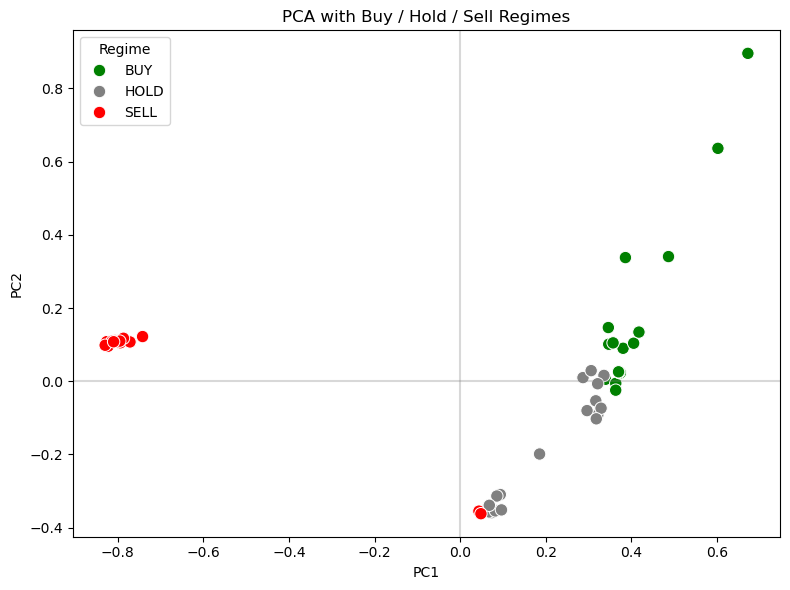

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=viz_df,
    x="PC1",
    y="PC2",
    hue="Regime",
    palette={"BUY": "green", "HOLD": "gray", "SELL": "red"},
    s=80
)

plt.title("PCA with Buy / Hold / Sell Regimes")
plt.axhline(0, color="gray", alpha=0.3)
plt.axvline(0, color="gray", alpha=0.3)
plt.tight_layout()
plt.show()


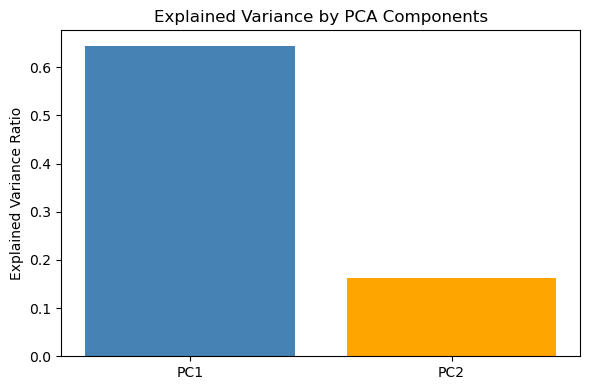

Explained variance ratios: [0.64431904 0.16232434]


In [20]:
plt.figure(figsize=(6, 4))
plt.bar(
    ["PC1", "PC2"],
    pca.explained_variance_ratio_,
    color=["steelblue", "orange"]
)
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by PCA Components")
plt.tight_layout()
plt.show()

print("Explained variance ratios:", pca.explained_variance_ratio_)


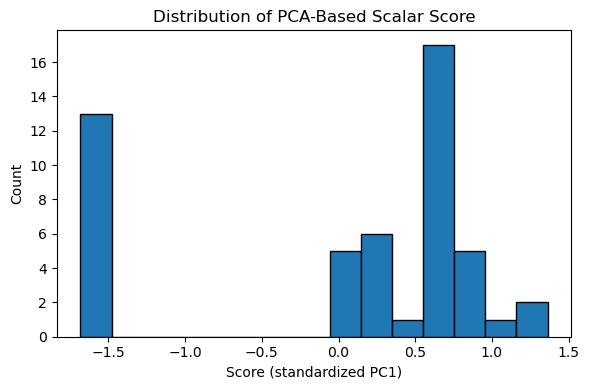

In [21]:
plt.figure(figsize=(6, 4))
plt.hist(scores, bins=15, edgecolor="black")
plt.title("Distribution of PCA-Based Scalar Score")
plt.xlabel("Score (standardized PC1)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


* The trained models and result metrics along with plots are saved.

In [22]:
import joblib

# Save fitted PCA model
joblib.dump(pca, "models/pca_scoring_model.joblib")

import torch

torch.save(
    {
        "encoder_state_dict": model.encoder.state_dict(),
        "embedding_dim": embeddings.shape[1],
        "price_features": feature_list
    },
    "models/price_encoder.pt"
)

import json

metadata = {
    "price_features": feature_list,
    "clinical_features": clin_features_scaled.columns.tolist(),
    "embedding_dim": embeddings.shape[1],
    "fusion_dim": X_fused.shape[1],
    "scoring_method": "PCA(1)",
    "regime_thresholds": {
        "buy": 0.7,
        "sell": 0.3
    }
}

with open("models/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

import pandas as pd

results_df = pd.DataFrame({
    "ticker": tickers,
    "score": scores,
    "percentile": percentiles,
})

results_df.to_csv("outputs/stock_scores_snapshot.csv", index=False)


In [23]:
pre_scale = pd.read_csv("data/pre_scale_clin.csv")

clinical_scaler = StandardScaler()
clinical_scaler.fit(pre_scale)

joblib.dump(
    clinical_scaler,
    "models/clinical_scaler.joblib"
)


['models/clinical_scaler.joblib']

# Backtesting - Validation for real world performance of model. 

* The model with saved weights, both LSTM for stock embeddings and PCA that combines with clinical data for regime classification is loaded.
* The embeddings are first initiated using minimum of 30 days until rebalanceing is done with performance metrics received. 
* Every 30 days, new embeddings are created with the saved weights of the model from which the top 30 percentile rank stocks are bought with equal weightage acting as a fresh composition of portfolio but with increasing knowledge stock embeddings derived from cumulative rebalanceing. 
* Look back days at maximum is set for the entire timestamp duration that is 755 days and during the beginning or stocks that are not populated for those days are masked, the normalisation and loss calculations are performed in a mask aware manner to maintain tensor dimension and model processing stability. 
* Data leakage is also prevented by strictly limitting the look back to previous timestamp data and by inhibiting look ahead.
* Various metrics are calculated at rebalanceing dates such as turnover rate, equity worth, annualised return, annualised volatility, rolling sharpe values, drawdown values and regimen stability which provides various information regarding the equity strategy performance. Along with the continouse performance according to the model a baseline is also established for comparison by buying all the stocks in the universe with equal weighatge -> Results are discussed along with respective plot output cells downstream.

Loading artifacts...
Price features: ['Open', 'High', 'Low', 'Close', 'Volume']
Clinical features: ['phase_1', 'phase_2', 'phase_3', 'phase_4', 'late_ratio', 'active_ratio']
Embedding dim: 32
Lookback days: 755
Encoder loaded.
Universe tickers: 50
Preparing backtest dates...
Number of rebalance dates: 24


/tmp/ipykernel_9730/498215044.py:213: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = pd.date_range(start=start_date + pd.DateOffset(months=12),
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[0/23] Rebalance 2021-02-28 -> 2021-03-31 | BUYs: 16 | PortRet: -0.0113


/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning

[6/23] Rebalance 2021-08-31 -> 2021-09-30 | BUYs: 16 | PortRet: -0.0496


/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning

[12/23] Rebalance 2022-02-28 -> 2022-03-31 | BUYs: 16 | PortRet: 0.0390


/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning

[18/23] Rebalance 2022-08-31 -> 2022-09-30 | BUYs: 16 | PortRet: -0.0514


/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/dharveeshgani/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



--- Performance Summary ---
Portfolio: {'total_periods': 23, 'cumulative_return': 1.4587288895638142, 'annual_return': 0.21773266782660028, 'annual_vol': 0.3955898935222633, 'sharpe': 0.5503999758132004, 'max_drawdown': -0.3305114260783826}
Benchmark: {'total_periods': 23, 'cumulative_return': 1.249355577619895, 'annual_return': 0.12316846377230739, 'annual_vol': 0.21387115414184799, 'sharpe': 0.5759003090740189, 'max_drawdown': -0.2401779407645125}
Average turnover per rebalance (approx): 0.002840909090909091
Average regime persistence: 0.9745454545454546


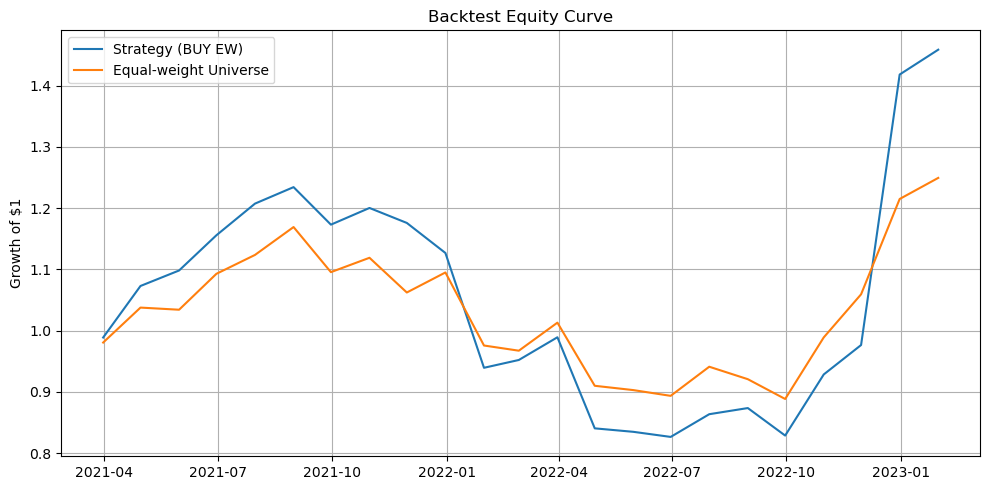

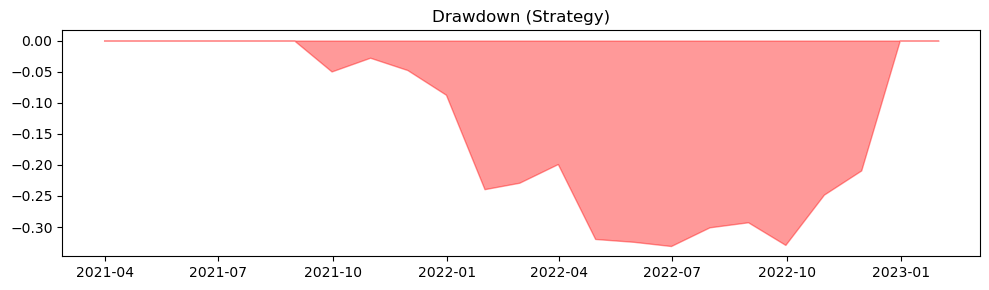

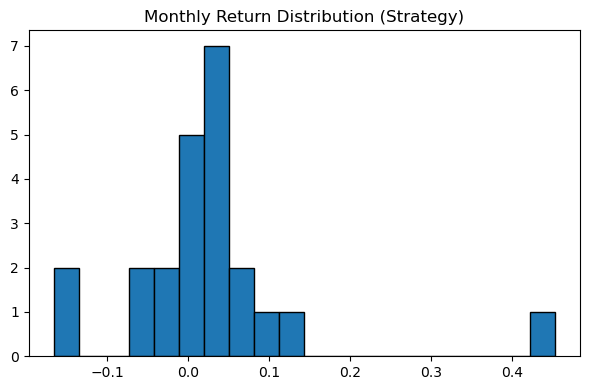

Backtest complete. Outputs saved to: outputs


In [24]:
# Walk-Forward Backtest

import os
import json
import joblib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from datetime import timedelta
import torch.nn as nn


MODELS_DIR = "models"
OUTPUTS_DIR = "outputs"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)

PCA_PATH = os.path.join(MODELS_DIR, "pca_scoring_model.joblib")
SCALER_PATH = os.path.join(MODELS_DIR, "clinical_scaler.joblib")
ENCODER_PATH = os.path.join(MODELS_DIR, "price_encoder.pt")
METADATA_PATH = os.path.join(MODELS_DIR, "model_metadata.json")

# Input CSVs or DataFrames
STOCK_CSV = "data/stock_csv.csv"      # must contain Date, ticker, Close and price features
CLINICAL_CSV = "data/clinical.csv"  # clinical features indexed by ticker or with 'ticker' column

# Backtest choices
REBALANCE_FREQ = "M"   # 'M' monthly; change to 'Q' quarterly if desired
MIN_HISTORY_DAYS = 30  # skip tickers with fewer than this many days of history at rebalance
LOOKBACK_DAYS_DEFAULT = 755  # fallback if metadata doesn't include lookback

# Regime thresholds (percentiles)
BUY_PCT = 0.70
SELL_PCT = 0.30

# Device for encoder inference
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import torch.nn as nn

class EncoderLSTM(nn.Module):
    """
    Minimal wrapper for the encoder LSTM as saved.
    It must match the architecture used when saving encoder_state_dict.
    """
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)

    def forward(self, x):
        # x: (batch, T, F)
        out, _ = self.lstm(x)  # out: (batch, T, hidden_dim)
        return out


print("Loading artifacts...")
pca = joblib.load(PCA_PATH)
clinical_scaler = joblib.load(SCALER_PATH)
checkpoint = torch.load(ENCODER_PATH, map_location="cpu")
with open(METADATA_PATH, "r") as f:
    metadata = json.load(f)

price_features = metadata.get("price_features")
clinical_features = metadata.get("clinical_features")
embedding_dim = metadata.get("embedding_dim")
# If lookback was stored:
lookback_days = metadata.get("lookback", LOOKBACK_DAYS_DEFAULT)

print("Price features:", price_features)
print("Clinical features:", clinical_features)
print("Embedding dim:", embedding_dim)
print("Lookback days:", lookback_days)

# Reconstruct encoder (must match original encoder naming)
input_dim = len(price_features)
hidden_dim = embedding_dim
encoder = torch.nn.LSTM(
    input_size=len(price_features),
    hidden_size=hidden_dim,
    num_layers=2,
    batch_first=True
)

encoder.load_state_dict(checkpoint["encoder_state_dict"])
encoder.to(DEVICE)
encoder.eval()
print("Encoder loaded.")


# Ensure Date column parsed as datetime
stock_df = pd.read_csv(STOCK_CSV, parse_dates=["Date"])
clinical_df = pd.read_csv(CLINICAL_CSV)
if "ticker" in clinical_df.columns:
    clinical_df = clinical_df.set_index("ticker")

# Normalize ticker names: ensure column 'ticker' exists in stock_df
if "ticker" not in stock_df.columns:
    if "Ticker" in stock_df.columns:
        stock_df = stock_df.rename(columns={"Ticker": "ticker"})
    else:
        raise ValueError("stock_df must have a 'ticker' column")

stock_df = stock_df.sort_values("Date").reset_index(drop=True)

# Get universe
all_tickers = sorted(stock_df["ticker"].unique())
print("Universe tickers:", len(all_tickers))


def build_price_matrix_for_date(stock_df, tickers, end_date, lookback_days):
   
    mats = []
    masks = []
    valid = []

    for tkr in tickers:
        df = stock_df[(stock_df["ticker"] == tkr) & (stock_df["Date"] <= end_date)].sort_values("Date")
   
        if df.shape[0] < MIN_HISTORY_DAYS:
            continue

        arr = df[price_features].values.astype(np.float32)  # (L, F)
        L = arr.shape[0]
        if L >= lookback_days:
            arr2 = arr[-lookback_days:]
            mask = np.ones(lookback_days, dtype=bool)
        else:
            pad_len = lookback_days - L
            arr2 = np.vstack([np.zeros((pad_len, arr.shape[1]), dtype=np.float32), arr])
            mask = np.zeros(lookback_days, dtype=bool)
            mask[pad_len:] = True

        mats.append(arr2)
        masks.append(mask)
        valid.append(tkr)

    if len(mats) == 0:
        return None, None, None

    price_tensor = np.stack(mats)  # (N_valid, lookback_days, F)
    mask_array = np.stack(masks)   # (N_valid, lookback_days)
    return price_tensor, valid, mask_array

def zscore_per_ticker_window(price_tensor, mask_array, eps=1e-8):
   
    N, T, F = price_tensor.shape
    out = np.zeros_like(price_tensor, dtype=np.float32)

    for i in range(N):
        obs_mask = mask_array[i]  # (T,)
        if obs_mask.sum() == 0:
            # leave zeros
            continue
        observed = price_tensor[i, obs_mask, :]  # (L, F)
        mean = np.nanmean(observed, axis=0)
        std = np.nanstd(observed, axis=0)
        std = np.where(std < eps, 1.0, std)
        # broadcast subtraction/division
        out[i] = (price_tensor[i] - mean) / std
        # any NaNs (from padded zeros) -> 0
        out[i] = np.nan_to_num(out[i], nan=0.0)
    return out

def encode_price_tensor(price_tensor_z):
    
    encoder.eval()
    with torch.no_grad():
        x = torch.tensor(price_tensor_z, dtype=torch.float32, device=DEVICE)
        encoded_seq, _ = encoder(x)  # unpack LSTM output
        encoded_seq = encoded_seq.cpu().numpy()

    # Mean pooling over time (consistent with how embeddings were originally computed)
    emb = encoded_seq.mean(axis=1)  # (N, hidden_dim)
    return emb

def compute_scores_and_regimes(embeddings, valid_tickers, clinical_df):
    
    # Subset clinical features to valid_tickers and clinical_features
    clin_sub = clinical_df.loc[valid_tickers, clinical_features].fillna(0.0)
    # Scale clinical features with saved scaler
    clin_scaled = clinical_scaler.transform(clin_sub.values)  # (N, C)

    # Fuse
    X_fused = np.hstack([embeddings, clin_scaled])  # (N, D)
    # PCA transform 
    pc1 = pca.transform(X_fused)[:, 0]
    # standardize pc1 (mean 0, std 1)
    pc1_s = (pc1 - pc1.mean()) / (pc1.std(ddof=0) + 1e-8)
    percentiles = rankdata(pc1_s).astype(float) / len(pc1_s)
    regimes = np.where(percentiles >= BUY_PCT, "BUY", np.where(percentiles <= SELL_PCT, "SELL", "HOLD"))

    df = pd.DataFrame({
        "ticker": valid_tickers,
        "score": pc1_s,
        "percentile": percentiles,
        "regime": regimes
    })
    return df, X_fused

# --------- 6. Backtest walk-forward loop ----------
print("Preparing backtest dates...")
# Prepare rebalance dates: run only on last trading day of each month
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
unique_dates = sorted(stock_df["Date"].unique())
start_date = unique_dates[0]  
end_date = unique_dates[-1]

# Build monthly end-of-month rebalance dates starting after first year (to ensure lookback)
rebalance_dates = pd.date_range(start=start_date + pd.DateOffset(months=12),
                                end=end_date, freq=REBALANCE_FREQ).to_pydatetime().tolist()

print("Number of rebalance dates:", len(rebalance_dates))

# Containers for results
bt_dates = []
bt_portfolio_returns = []   # portfolio return for each period
bt_benchmark_returns = []    # equal-weight universe return
scores_history = []          # store scoring DF per date
weights_history = []         # list of dict date-> {ticker:weight}
holdings_history = []        # list of tickers in BUY each period

# For each rebalance date, compute embeddings and regimes using only data <= t0;
# then hold until next rebalance date t1 and compute forward return.
for idx in range(len(rebalance_dates) - 1):
    t0 = rebalance_dates[idx]
    t1 = rebalance_dates[idx + 1]
    # Build price matrix up to t0
    price_tensor, valid_tickers, mask_array = build_price_matrix_for_date(stock_df, all_tickers, t0, lookback_days)
    if price_tensor is None:
        continue

    # z-score per ticker using observed window (same method used during training)
    price_tensor_z = zscore_per_ticker_window(price_tensor, mask_array)

    # Encode
    embeddings = encode_price_tensor(price_tensor_z)  # (N, embed_dim)

    # Score and regimes
    scores_df, fused_features = compute_scores_and_regimes(embeddings, valid_tickers, clinical_df)

    # Save scores snapshot
    scores_df["rebalance_date"] = pd.to_datetime(t0)
    scores_history.append(scores_df)

    # Build BUY mask & weights (equal-weight among BUY)
    buy_df = scores_df[scores_df["regime"] == "BUY"]
    buy_list = buy_df["ticker"].tolist()
    if len(buy_list) == 0:
        # no buys this period -> zero return
        bt_portfolio_returns.append(0.0)
        bt_benchmark_returns.append(0.0)
        bt_dates.append(t1)
        weights_history.append({})
        holdings_history.append([])
        continue

    weights = {tkr: 1.0 / len(buy_list) for tkr in buy_list}
    weights_history.append(weights)
    holdings_history.append(buy_list)

    # Compute forward returns from t0 -> t1 for valid tickers
    per_ticker_rets = {}
    for tkr in valid_tickers:
        df_window = stock_df[(stock_df["ticker"] == tkr) & (stock_df["Date"] > t0) & (stock_df["Date"] <= t1)].sort_values("Date")
        # If no prices in forward window, use 0 return
        if df_window.shape[0] < 1:
            per_ticker_rets[tkr] = 0.0
        else:
            # entry price = last close at or before t0 (we used history up to t0)
            # exit price = last close <= t1 (we take last in forward window)
            # find last close <= t0 for entry
            df_hist = stock_df[(stock_df["ticker"] == tkr) & (stock_df["Date"] <= t0)].sort_values("Date")
            if df_hist.shape[0] < 1:
                per_ticker_rets[tkr] = 0.0
            else:
                entry_px = df_hist["Close"].iloc[-1]
                exit_px = df_window["Close"].iloc[-1]
                if entry_px == 0:
                    per_ticker_rets[tkr] = 0.0
                else:
                    per_ticker_rets[tkr] = (exit_px / entry_px) - 1.0

    # Portfolio return: weighted over BUY list
    rets_vec = np.array([per_ticker_rets.get(tkr, 0.0) for tkr in buy_list])
    weights_vec = np.array([weights[tkr] for tkr in buy_list])
    port_ret = float(np.dot(weights_vec, rets_vec))

    # Benchmark: equal-weight across all valid tickers
    all_rets = np.array([per_ticker_rets.get(tkr, 0.0) for tkr in valid_tickers])
    bench_ret = float(all_rets.mean())

    bt_portfolio_returns.append(port_ret)
    bt_benchmark_returns.append(bench_ret)
    bt_dates.append(t1)

    # Logging concise progress
    if (idx % 6) == 0:
        print(f"[{idx}/{len(rebalance_dates)-1}] Rebalance {t0.date()} -> {t1.date()} | BUYs: {len(buy_list)} | PortRet: {port_ret:.4f}")

# Convert results to Series/DataFrame
bt_index = pd.to_datetime(bt_dates)
returns_series = pd.Series(bt_portfolio_returns, index=bt_index)
bench_series = pd.Series(bt_benchmark_returns, index=bt_index)

# --------- 7. Performance metrics ----------
def compute_performance(returns, periods_per_year=12):
    """
    returns: pd.Series of period returns (e.g. monthly)
    """
    returns = returns.dropna()
    if len(returns) == 0:
        return {}
    cumulative = (1 + returns).cumprod()
    total_periods = len(returns)
    annual_return = cumulative.iloc[-1] ** (periods_per_year / total_periods) - 1.0
    ann_vol = returns.std() * (periods_per_year ** 0.5)
    sharpe = (annual_return / ann_vol) if ann_vol > 0 else np.nan
    drawdown = cumulative / cumulative.cummax() - 1.0
    max_dd = drawdown.min()
    sr = sharpe
    return {
        "total_periods": total_periods,
        "cumulative_return": float(cumulative.iloc[-1]),
        "annual_return": float(annual_return),
        "annual_vol": float(ann_vol),
        "sharpe": float(sr),
        "max_drawdown": float(max_dd)
    }

perf_port = compute_performance(returns_series)
perf_bench = compute_performance(bench_series)

print("\n--- Performance Summary ---")
print("Portfolio:", perf_port)
print("Benchmark:", perf_bench)

# --------- 8. Turnover and regime stability ----------
# Turnover: fraction of weight changed between successive periods (simple measure)
turnover_vals = []
for i in range(1, len(weights_history)):
    prev = weights_history[i-1]
    curr = weights_history[i]
    # union of tickers
    union = set(prev.keys()).union(curr.keys())
    # compute l1 distance in weights
    s = sum(abs(prev.get(k, 0.0) - curr.get(k, 0.0)) for k in union)
    turnover_vals.append(s / 2.0)  # l1/2 is typical turnover normalization

avg_turnover = float(np.mean(turnover_vals)) if len(turnover_vals) > 0 else 0.0
print("Average turnover per rebalance (approx):", avg_turnover)

# Regime persistence: fraction of tickers that keep same regime between periods (using scores_history)
persistence_vals = []
for i in range(1, len(scores_history)):
    a = scores_history[i-1].set_index("ticker")["regime"]
    b = scores_history[i].set_index("ticker")["regime"]
    common = a.index.intersection(b.index)
    if len(common) == 0:
        continue
    same = (a.loc[common] == b.loc[common]).sum()
    persistence_vals.append(same / len(common))
avg_persistence = float(np.mean(persistence_vals)) if len(persistence_vals) > 0 else np.nan
print("Average regime persistence:", avg_persistence)

# --------- 9. Visualisations ----------
plt.style.use("default")
# Equity curve
cum_port = (1 + returns_series).cumprod()
cum_bench = (1 + bench_series).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cum_port.index, cum_port.values, label="Strategy (BUY EW)")
plt.plot(cum_bench.index, cum_bench.values, label="Equal-weight Universe")
plt.title("Backtest Equity Curve")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, "equity_curve.png"))
plt.show()

# Drawdown
drawdown = cum_port / cum_port.cummax() - 1.0
plt.figure(figsize=(10,3))
plt.fill_between(drawdown.index, drawdown.values, 0, color="red", alpha=0.4)
plt.title("Drawdown (Strategy)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, "drawdown.png"))
plt.show()

# Monthly returns histogram
plt.figure(figsize=(6,4))
plt.hist(returns_series.dropna().values, bins=20, edgecolor="k")
plt.title("Monthly Return Distribution (Strategy)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, "returns_hist.png"))
plt.show()

# --------- 10. Save outputs (scores history, weights, results) ----------
# Flatten scores_history to single DataFrame
scores_all = pd.concat(scores_history, ignore_index=True)
scores_all.to_csv(os.path.join(OUTPUTS_DIR, "scores_history.csv"), index=False)

# Save portfolio returns
results_df = pd.DataFrame({
    "date": bt_index,
    "strategy_return": returns_series.values,
    "benchmark_return": bench_series.values,
    "strategy_cumulative": cum_port.values,
    "benchmark_cumulative": cum_bench.values
})
results_df.to_csv(os.path.join(OUTPUTS_DIR, "backtest_results.csv"), index=False)

# Save weights history as DataFrame (rows=periods, columns=tickers)
weights_df = pd.DataFrame.from_records(weights_history).fillna(0.0)
weights_df["rebalance_date"] = bt_index
weights_df.to_csv(os.path.join(OUTPUTS_DIR, "weights_history.csv"), index=False)

# Save summary metrics
summary = {
    "strategy": perf_port,
    "benchmark": perf_bench,
    "avg_turnover": avg_turnover,
    "avg_persistence": avg_persistence,
    "n_periods": len(returns_series)
}
with open(os.path.join(OUTPUTS_DIR, "backtest_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Backtest complete. Outputs saved to:", OUTPUTS_DIR)


* The above plots indicate that equity strategy devised by the regime selection based model performs better than naive baseline during the begeinning while occassionally performing worse when general market is bearish but results in significantly higher returns during bullish phases than baseline.
* It indicates a high risk - high reward strategy with higher volatility and higher returns resulting in non-optimal sharpe values.
* Drawdown values indicate the same trend that reflects with the normal behaviour of biotech market that disrupts in either direction driven by events rather than a continous market performance distribution alone.
* Monthly returns and regime consistency show relative stability albeit with certain huge spikes that affirm the above market behaviour.

In [25]:
from collections import defaultdict

per_ticker_rets_history = []   # list of dicts, one per period

for i in range(len(rebalance_dates) - 1):
    start = rebalance_dates[i]
    end   = rebalance_dates[i + 1]

    period_rets = {}

    # iterate over ALL tickers 
    for tkr in valid_tickers:
        df_t = stock_df[stock_df["ticker"] == tkr]

        # prices at rebalance dates
        p0 = df_t.loc[df_t["Date"] <= start, "Close"]
        p1 = df_t.loc[df_t["Date"] <= end, "Close"]

        if len(p0) == 0 or len(p1) == 0:
            continue

        r = (p1.iloc[-1] / p0.iloc[-1]) - 1.0
        period_rets[tkr] = r

    per_ticker_rets_history.append(period_rets)

print("Built per_ticker_rets_history for", len(per_ticker_rets_history), "periods")

Built per_ticker_rets_history for 23 periods


* By this strategy the cumulative return contribution by each ticker across the entire time period shows a majority of tickers contributing equal weightage with around 3 of outperforming significantly thus being the major contributors.
* Two stocks are being repeatedly picked by the model for buying despite losses across time period of trading warranting further invesitgation, likely due to PCA based clinical misinterpretation due to inherent noise in clinical dataset, rather than LSTM embedding error.

In [26]:
# compute per-ticker cumulative contribution across periods
from collections import defaultdict
contrib = defaultdict(float)

for i, buy_list in enumerate(holdings_history):
   
    for tkr in buy_list:
        contrib[tkr] += per_ticker_rets_history[i].get(tkr, 0.0) / len(buy_list)


contrib_df = pd.DataFrame.from_dict(contrib, orient='index', columns=['cum_contrib']).sort_values('cum_contrib', ascending=False)
print(contrib_df.head(20))


      cum_contrib
MDGL     0.182541
SMMT     0.168519
BNTX     0.050970
ALNY     0.039420
LLY      0.038661
MEDP     0.029864
GILD     0.029225
MTD      0.026233
RMD      0.016906
ISRG     0.010495
IDXX     0.004856
JNJ      0.002828
EW       0.000594
VTRS     0.000138
ONC     -0.001587
ZBH     -0.009573
BBIO    -0.084434


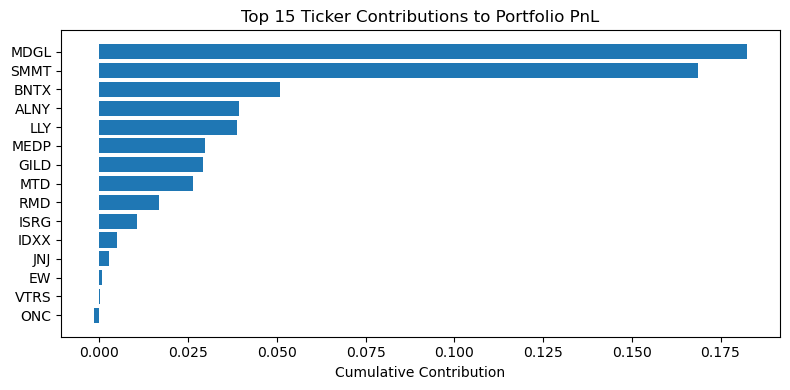

In [27]:
import matplotlib.pyplot as plt

top = contrib_df.head(15)
plt.figure(figsize=(8,4))
plt.barh(top.index[::-1], top["cum_contrib"].values[::-1])
plt.title("Top 15 Ticker Contributions to Portfolio PnL")
plt.xlabel("Cumulative Contribution")
plt.tight_layout()
plt.show()


In [28]:

from collections import defaultdict
contrib = defaultdict(float)
for i, weights in enumerate(weights_history):

    per_rets = per_ticker_rets_history[i]
    for tkr, w in weights.items():
        contrib[tkr] += w * per_rets.get(tkr, 0.0)

contrib_df = pd.Series(contrib).sort_values(ascending=False)
contrib_df.head(20)


MDGL    0.182541
SMMT    0.168519
BNTX    0.050970
ALNY    0.039420
LLY     0.038661
MEDP    0.029864
GILD    0.029225
MTD     0.026233
RMD     0.016906
ISRG    0.010495
IDXX    0.004856
JNJ     0.002828
EW      0.000594
VTRS    0.000138
ONC    -0.001587
ZBH    -0.009573
BBIO   -0.084434
dtype: float64

* The plot below indicates that the churn rate or stretegy instability is comparable to baseline and does not incur exhorbitant transaction and trading charges which is desirable.

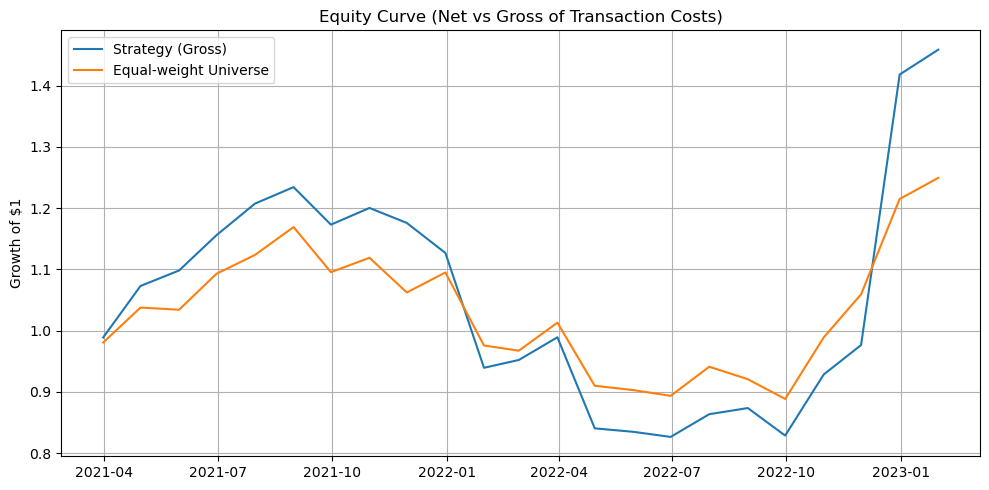

In [29]:
import pandas as pd

tc = 0.001  # 10 bps
net_returns = []
prev_weights = {}
for i in range(len(weights_history)):
    w = weights_history[i]
    # compute turnover
    union = set(prev_weights.keys()).union(w.keys())
    turnover = sum(abs(prev_weights.get(k,0)-w.get(k,0)) for k in union)/2.0
    gross = bt_portfolio_returns[i]
    net = gross - tc * turnover
    net_returns.append(net)
    prev_weights = w
# compute new cumulative from net_returns
import matplotlib.pyplot as plt

net_returns_series = pd.Series(net_returns, index=bt_index)
cum_net = (1 + net_returns_series).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cum_port.index, cum_port.values, label="Strategy (Gross)")
plt.plot(cum_bench.index, cum_bench.values, label="Equal-weight Universe")
plt.title("Equity Curve (Net vs Gross of Transaction Costs)")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* The rolling sharpe values indicate drop to negative values during atleast 5 months indicating that the model kept buying the dip unaware of overall biotech market loss during those months but later see recovery with high sharpe values as the model learns. 

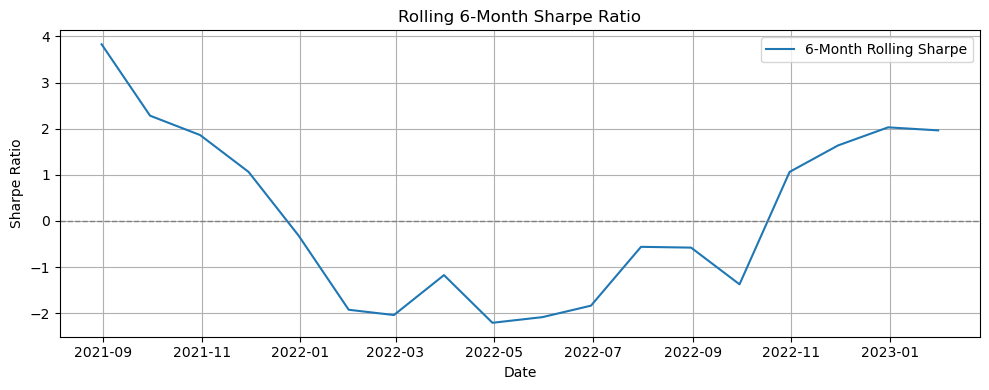

In [30]:
window = 6
roll_sharpe = returns_series.rolling(window).mean() / returns_series.rolling(window).std() * (12**0.5)
plt.figure(figsize=(10, 4))
plt.plot(roll_sharpe.index, roll_sharpe.values, label=f"{window}-Month Rolling Sharpe")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title(f"Rolling {window}-Month Sharpe Ratio")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* Performance attribution analysis shows that MDGL (Madrigal Pharmaceuticals) and SMMT (Summit Therapeutics) are the major contributors of profit alongside several tickers indicated by other green and the consolidated 'OTHER' bar in red also having significant contribution when taken together. This results from the waterfall plot shows that the model does not rely on one or two lucky picks but executes trades in an overall healthy manner with primarily positive prediction of all the stocks in the universe.
* The monthly contribution chart per ticker shows that the model was successful in predicting the rise in value of the above mentioned stock during september of 2022 before it happened and executed the trade resulting in a huge return. This implies the capabilty of the model in predicting surge of performance in stocks before the disruptive event capable of producing large returns. 
* The rest of the months show mixed and continouse stock buy portfolio and this overall behavious is typical of the Biotech market which the model was able to learn fairly well.

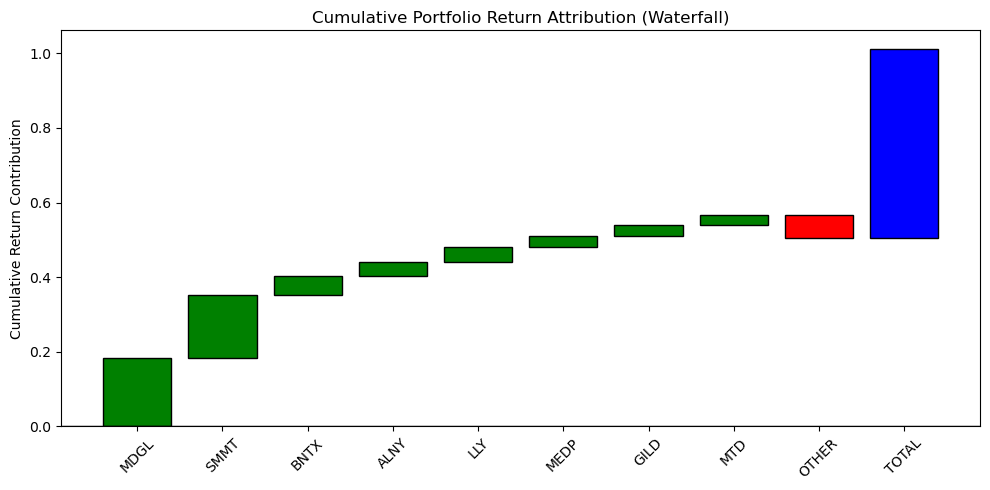

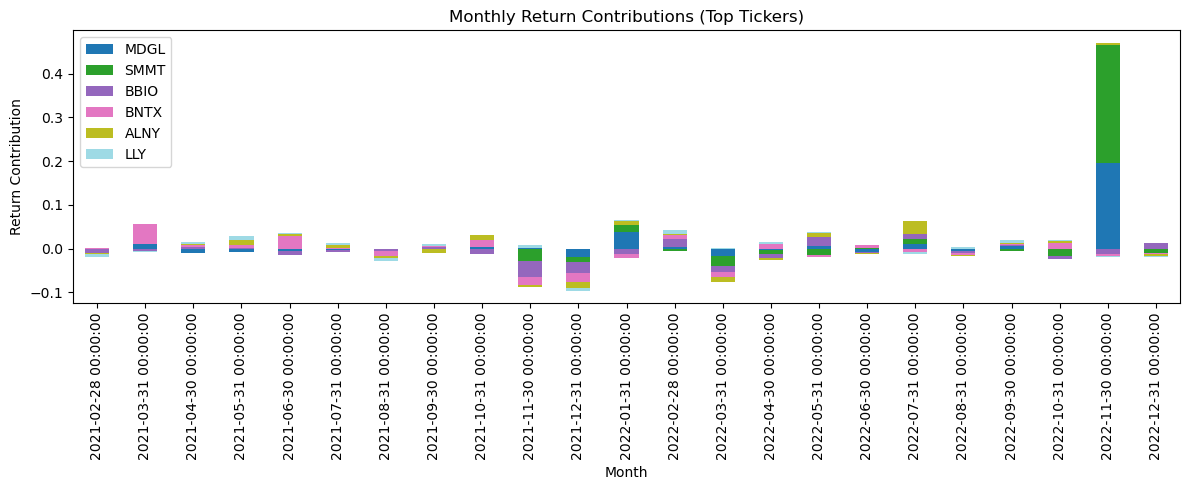

In [31]:
from collections import defaultdict
import pandas as pd
import numpy as np

def compute_per_ticker_monthly_returns(stock_df, tickers, rebalance_dates):
    """
    Returns:
        per_ticker_rets_history: list of dicts
            index i -> {ticker: return from rebalance_dates[i] to i+1}
    """
    per_ticker_rets_history = []

    for i in range(len(rebalance_dates) - 1):
        start = rebalance_dates[i]
        end   = rebalance_dates[i + 1]

        period_rets = {}

        for tkr in tickers:
            df_t = stock_df[stock_df["ticker"] == tkr]

            p0 = df_t.loc[df_t["Date"] <= start, "Close"]
            p1 = df_t.loc[df_t["Date"] <= end,   "Close"]

            if len(p0) == 0 or len(p1) == 0:
                continue

            period_rets[tkr] = (p1.iloc[-1] / p0.iloc[-1]) - 1.0

        per_ticker_rets_history.append(period_rets)

    return per_ticker_rets_history

per_ticker_rets_history = compute_per_ticker_monthly_returns(
    stock_df,
    valid_tickers,
    rebalance_dates
)

def compute_monthly_contributions(
    holdings_history,
    per_ticker_rets_history,
    rebalance_dates
):
    """
    Returns:
        contrib_df: DataFrame
            rows   = months
            cols   = tickers
            values = contribution to portfolio return
    """
    months = rebalance_dates[:-1]
    contrib = defaultdict(list)

    for i, buy_list in enumerate(holdings_history):
        if len(buy_list) == 0:
            for tkr in valid_tickers:
                contrib[tkr].append(0.0)
            continue

        w = 1.0 / len(buy_list)

        for tkr in valid_tickers:
            r = per_ticker_rets_history[i].get(tkr, 0.0)
            contrib[tkr].append(w * r if tkr in buy_list else 0.0)

    contrib_df = pd.DataFrame(contrib, index=months)
    return contrib_df

monthly_contrib_df = compute_monthly_contributions(
    holdings_history,
    per_ticker_rets_history,
    rebalance_dates
)

def prepare_waterfall(contrib_df, top_k=8):
    """
    Aggregates contributions across all months.
    """
    total_contrib = contrib_df.sum(axis=0).sort_values(ascending=False)

    top = total_contrib.head(top_k)
    rest = total_contrib.iloc[top_k:].sum()

    waterfall = top.copy()
    waterfall["OTHER"] = rest
    waterfall["TOTAL"] = total_contrib.sum()

    return waterfall

waterfall_data = prepare_waterfall(monthly_contrib_df, top_k=8)

import matplotlib.pyplot as plt

def plot_contribution_waterfall(waterfall_data):
    labels = waterfall_data.index
    values = waterfall_data.values

    cum = np.cumsum(np.insert(values[:-1], 0, 0))

    plt.figure(figsize=(10,5))

    colors = ["green" if v > 0 else "red" for v in values]
    colors[-1] = "blue"  # TOTAL

    plt.bar(labels, values, bottom=cum, color=colors, edgecolor="black")

    plt.axhline(0, color="black", linewidth=1)
    plt.title("Cumulative Portfolio Return Attribution (Waterfall)")
    plt.ylabel("Cumulative Return Contribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
plot_contribution_waterfall(waterfall_data)

def plot_monthly_stack(contrib_df, top_k=6):
    top = contrib_df.sum().abs().sort_values(ascending=False).head(top_k).index
    df = contrib_df[top]

    plt.figure(figsize=(12,5))
    df.plot(kind="bar", stacked=True, colormap="tab20", ax=plt.gca())
    plt.title("Monthly Return Contributions (Top Tickers)")
    plt.ylabel("Return Contribution")
    plt.xlabel("Month")
    plt.tight_layout()
    plt.show()
    
plot_monthly_stack(monthly_contrib_df)


# Statistical Analysis

* To test the statistical significance of the model's decisions and the resulting outcome compared to the one's taken by a naive model is to be determined by various significance test. 
* We use Student's T-test to evaluate portfolio vs benchmark performance along with ANOVA for evaluating regimen differentiaition significance.
* Both the tests yielded negative results ie: the model's findings were deemed by chance rather than concrete decisions including for the case of regimen classification.
* This is primarily due to very low sample number (24 months) according our backtest rebalanceing interval and the functioning of the model itself that does not act like a institutional fund manager that takes every decision of stock turnover that has guaranteed returns of some form big or small relying mainly on sharpe ratio values, but rather like a venture capitalist that invests in a lot of stocks with the intuition that one or a few of them might extensively perform well pulling the cumulative returns of the total investment really high during exit.
* This method of moonshot trading is heavily penalised by standard statistical validation methods including the ANOVA and T-Test that considers standard deviation of values to both negative and positive side as a penalising factor, ie: wether the investor makes money or loses money abruptly in high quantities that is penalised and is considered as risk based on randomness.
* These methods do injustice to our model's core functional behaviour of trading which is clearly indicated by Sortino Ratio implemented here as our final evaluation metric that outputs almost double the value compared to sharpe ratio which acts as an explanation to above p-value failures and it's statistical shortcoming as a proper evaluation criteria for the model here. Sortino ratio is a modification to Sharpe ratio, here the ratio explicitly penalises standard deviation to negative ends only skipping positive deviations which is ideal for stock market trading. The investors decisions should only be penalised if they result in loss of invested capital proportionally larger to the loss incurred and not for the profit obtained however deviated from the benchmark or mean of the distribution is. Especially in the case of our model from monthwise ticker contribution plot we observed that during the final months the model predicted an abrupt positive oppurtunity and profitted hugely from it compared to baseline naive models.

--- Student's t-test Results ---
T-statistic: 0.7172
P-value:     0.4808
Result: NOT SIGNIFICANT (Cannot rule out luck due to small sample size)


--- One-Way ANOVA Results (Regime Separation) ---
F-statistic: 0.8992
P-value:     0.4072
Result: NOT SIGNIFICANT (Buy/Hold/Sell performance is not statistically distinguishable)


/tmp/ipykernel_9730/4171354916.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_anova, x='Regime', y='Return', order=['SELL', 'HOLD', 'BUY'], palette={'SELL': 'red', 'HOLD': 'grey', 'BUY': 'green'})


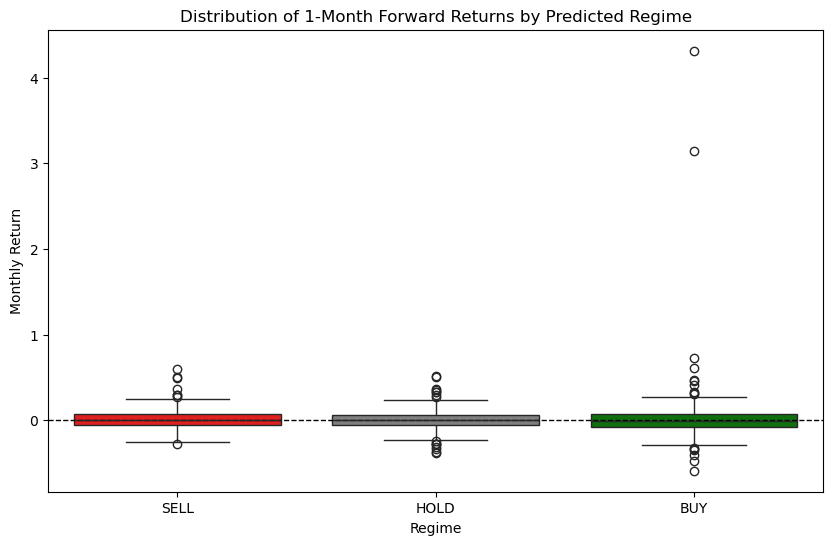

In [32]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Student's t-test (Portfolio vs Benchmark)

active_returns = returns_series.values - bench_series.values
t_stat, p_val_t = stats.ttest_1samp(active_returns, 0)

print(f"--- Student's t-test Results ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value:     {p_val_t:.4f}")
if p_val_t < 0.05:
    print("Result: SIGNIFICANT (The strategy statistically beats the benchmark)")
else:
    print("Result: NOT SIGNIFICANT (Cannot rule out luck due to small sample size)")
print("\n")


# ANOVA on Regimes (Buy vs Hold vs Sell)
regime_data = []

# Iterate through history to calculate forward return for each stock in each regime
for i in range(len(scores_history) - 1):
    current_date = scores_history[i]['rebalance_date'].iloc[0]
    next_date = scores_history[i+1]['rebalance_date'].iloc[0]
    
    # Get scores/regimes for this month
    monthly_scores = scores_history[i]
    
    # Calculate returns for all stocks in this month
    for _, row in monthly_scores.iterrows():
        ticker = row['ticker']
        regime = row['regime']
        
        # Get price at start and end of month
        p_start = stock_df[(stock_df['ticker'] == ticker) & (stock_df['Date'] <= current_date)]['Close']
        p_end = stock_df[(stock_df['ticker'] == ticker) & (stock_df['Date'] <= next_date)]['Close']
        
        if not p_start.empty and not p_end.empty:
            ret = (p_end.iloc[-1] / p_start.iloc[-1]) - 1.0
            regime_data.append({'Regime': regime, 'Return': ret})

df_anova = pd.DataFrame(regime_data)

# Run ANOVA
groups = [df_anova[df_anova['Regime'] == r]['Return'].values for r in ['BUY', 'HOLD', 'SELL']]
f_stat, p_val_anova = stats.f_oneway(*groups)

print(f"--- One-Way ANOVA Results (Regime Separation) ---")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value:     {p_val_anova:.4f}")
if p_val_anova < 0.05:
    print("Result: SIGNIFICANT (The model successfully separates stocks into different performance tiers)")
else:
    print("Result: NOT SIGNIFICANT (Buy/Hold/Sell performance is not statistically distinguishable)")


plt.figure(figsize=(10, 6))

sns.boxplot(data=df_anova, x='Regime', y='Return', order=['SELL', 'HOLD', 'BUY'], palette={'SELL': 'red', 'HOLD': 'grey', 'BUY': 'green'})
plt.title('Distribution of 1-Month Forward Returns by Predicted Regime')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylabel('Monthly Return')
plt.show()

--- Risk-Adjusted Return Comparison ---
Sharpe Ratio (Penalizes Upside):  0.6669
Sortino Ratio (Ignores Upside):   1.2611
Result: Sortino > Sharpe. This confirms the 'Convex Payoff' profile.
      (The strategy's volatility is driven more by winners than losers.)


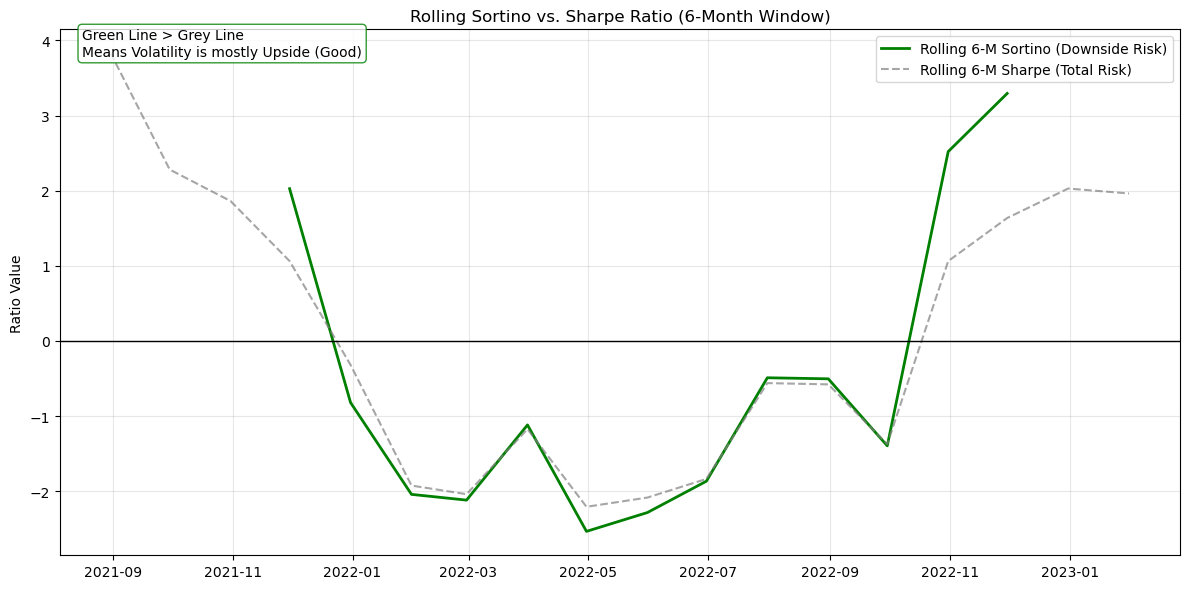

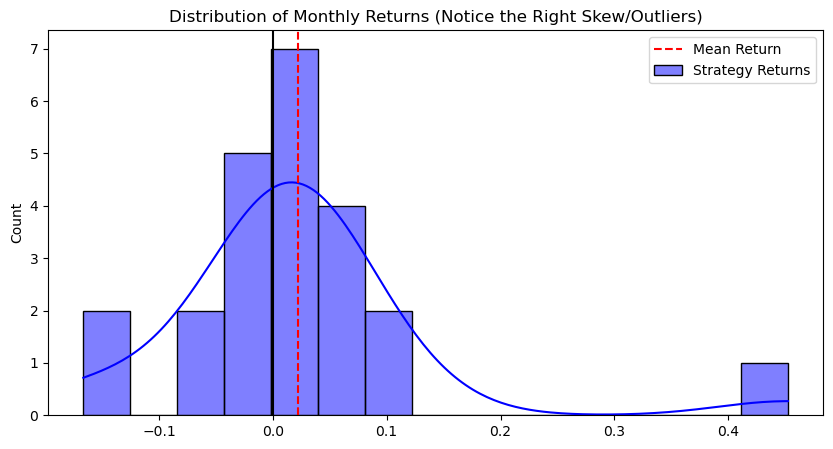

In [33]:

# SORTINO RATIO ANALYSIS 

def calculate_sortino(series, target=0, periods=12):
    mean = series.mean() * periods
    # Filter for only negative returns (downside)
    downside = series[series < target]
    # Calculate downside deviation
    downside_std = downside.std() * np.sqrt(periods)
    
    if downside_std == 0:
        return np.nan
    return (mean - target) / downside_std

# 1. Calculate Scalar Metrics
strat_sharpe = (returns_series.mean() / returns_series.std()) * np.sqrt(12)
strat_sortino = calculate_sortino(returns_series)

print("--- Risk-Adjusted Return Comparison ---")
print(f"Sharpe Ratio (Penalizes Upside):  {strat_sharpe:.4f}")
print(f"Sortino Ratio (Ignores Upside):   {strat_sortino:.4f}")

if strat_sortino > strat_sharpe:
    print("Result: Sortino > Sharpe. This confirms the 'Convex Payoff' profile.")
    print("      (The strategy's volatility is driven more by winners than losers.)")

# 2. Rolling Window Analysis
window = 6
rolling_mean = returns_series.rolling(window).mean()
rolling_std = returns_series.rolling(window).std()

# Custom rolling downside deviation
def rolling_downside_std(x):
    negative_rets = x[x < 0]
    if len(negative_rets) < 2: 
        return np.nan # Not enough data for std dev
    return negative_rets.std(ddof=1)

rolling_down_std = returns_series.rolling(window).apply(rolling_downside_std)

# Annualize rolling metrics
roll_sharpe = (rolling_mean / rolling_std) * np.sqrt(12)
roll_sortino = (rolling_mean / rolling_down_std) * np.sqrt(12)

# 3. Visualization
plt.figure(figsize=(12, 6))

plt.plot(roll_sortino.index, roll_sortino.values, label=f'Rolling {window}-M Sortino (Downside Risk)', color='green', linewidth=2)
plt.plot(roll_sharpe.index, roll_sharpe.values, label=f'Rolling {window}-M Sharpe (Total Risk)', color='gray', linestyle='--', alpha=0.7)

plt.axhline(0, color='black', linewidth=1)
plt.title(f'Rolling Sortino vs. Sharpe Ratio ({window}-Month Window)')
plt.ylabel('Ratio Value')
plt.legend()
plt.grid(True, alpha=0.3)


plt.annotate('Green Line > Grey Line\nMeans Volatility is mostly Upside (Good)', 
             xy=(0.02, 0.95), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
sns.histplot(returns_series, kde=True, color='blue', label='Strategy Returns')
plt.axvline(0, color='black', linestyle='-')
plt.axvline(returns_series.mean(), color='red', linestyle='--', label='Mean Return')
plt.title("Distribution of Monthly Returns (Notice the Right Skew/Outliers)")
plt.legend()
plt.show()

# RESULTS AND ANALYSIS 
* The Sortino ratio of ~1.3 which is almost double of sharpe ratio of ~0.65 is the defining metric that overcomes the limitations of validity posed by ANOVA and T-test p values of significance much higher than the threshold 0.05 used. These values also explains the behaviour of the model function as a risk tolerant high reward seeking broad investor.
* The above evaluations and metrics indicate that the model performed well in its objective of being an excellent representor of the biotech market for a specific time period by successfully integrating stock and clinical multimodality proving both do play a role in investment decision in this specific market.
* Rather than being a production ready investment engine this serves as a proof of concept exploratory model for regime classification of stocks in this market that could be refined with feature engineering and expanded datasets with rigourous multi model baselines to be used in real world market specific to biotechnology and pharmaceutical domain. 
* The model successfully shows the signal of an alpha strategy that oupterforms the naive beta movement with a moonshot strategy rather than a risk averse strategy and this approach is validated with the significant sortino ratio compared to sharpe value.

# CONCLUSION 
* The project successfully demonstrates that an unsupervised, multimodal representation learning framework offers a viable path for understanding the unconventional landscape of biotech market.
* The model achieved three main objectives:
    1. Multimodal success by fusion of temporal market features via an LSTM autoencoder with technical maturity of the company via PCA to uncover latent structures that unimodal implementations would have missed
    2. Regime discovery success using PCA score based ranking proved to be a reliable identifier of investment regimes without the need for dense labelled data validated by backtests.
    3. Alpha strategy presence was demonstrated with the equity curve that ultimately observed higher returns than the beta riding baseline further validated by a respectable sortino ratio value. The model functions like an investment regime identifier, that is a risk tolerant "Moonshot" screener, accumulating broad number of stocks with a potential for abrupt and disproportionate upside resulting in high reward. 

# FUTURE SCOPE AND IMPROVEMENTS
* To graduate this from a proof of concept approach to production ready investment engine, several expansions and exhaustive ablation tests with other model architectures are necessary.
* Expanding the dataset to include multiple points of clinical trial data clubbed with temporal stock data spanning associated years for a larger time period could be utilised that may increase the t-test and significance values as the increasing number of samples combat the volatility induced deviation punishment.
* Subsequently with increased samples multiple relevant synthetic features could engineered such as BioBERT or other LLM based imbedding of clinical trial summaries if found valuable.
* If the dataset proves to be dense and rich enough more complex models such as Temporal Fusion Transformers or sequence variants of attention mechanism based models can be implemented in place of LSTM for better understanding of stock behaviour. 

#### DISCLAIMER

* This project is academic and exploratory in nature. It is not financial advice and should not be used for live trading without extensive validation, stress testing, and risk controls.
  
* Certain sections of the notebook contains boilerplate code generated by AI models (Gemini and OpenAI) for efficiency and to mitigate time limitation, although with manual tweaking and significant manual review/changes wherever needed.
  
* Before running the notebook follow the file structure according to the repository strictly and go through the requirements.txt file for installing necessary dependencies.

* Run the below command in terminal within the downloaded repository directory 
pip install -r requirements.txt

* A detailed report on this project is accessible through the below google docs link:
https://docs.google.com/document/d/1ZgGAmxs9QU9MhB2-M6NvHlqMyzamXVcNWLTxeCYUxpw/edit?usp=sharing
(Generative AI was not used in the making of this document)

* A presentation with detailed explanation of the project is available through the following unlisted youtube link along with the google slides link for accessing the slides used in the presentation:
https://www.youtube.com/watch?v=ofXqQ-7hneo
https://docs.google.com/presentation/d/1BVXR-qfgVvoC35EWBTZtVd6gbKRkREfF7NfxUHho4Ec/edit?usp=sharing
(Parts of the slide have been generated using inline Gemini models for inforgraphics and design. No AI was used for generation of plots attached with evaluations as the same can be replicated and seen in the primary notebook present in the Github Repository)

* A dashboard containing a high level overview of the project is available that was vibe coded using lovable platform:
https://biotech-ai.lovable.app/

* Link to the main github repository with original file structure is given below:
https://github.com/Dharveesh-Gani/Capstone_Project_MinorinAI